In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from transformers import BertTokenizer, BertModel
import torch
torch.cuda.is_available()


True

## Загрузка данных

In [4]:
features_file = r'C:\ML\28_final_task\D_Online_Retail.xlsx'
df = pd.read_excel(features_file)
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         9   
1    536365     71053                  WHITE METAL LANTERN        10   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         9   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         7   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         9   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55       17850  United Kingdom  
1 2010-12-01 08:26:00       3.39       17850  United Kingdom  
2 2010-12-01 08:26:00       2.75       17850  United Kingdom  
3 2010-12-01 08:26:00       3.39       17850  United Kingdom  
4 2010-12-01 08:26:00       3.39       17850  United Kingdom

## Подготовка данных для кластеризации товаров и предсказания продаж по категориям

In [5]:
## функция очистки значений
def check_descriptions(value):
    if type(value) == str:
        if (len(value) < 2) or '?' in value:
            return "Прочие"
    return value

In [6]:
df['Description'] = df['Description'].map(lambda x: check_descriptions(x))

#### Пред обработка данных, для исключения пропусков и замены пустых значений

In [7]:
import warnings
warnings.filterwarnings("ignore")

df['Description'].fillna('Прочие', inplace=True)
# df['CustomerID'].fillna(-999999, inplace=True)
df['InvoiceNo'].fillna('без номера', inplace=True)
df['Return'] = df['InvoiceNo'].astype(str).str.startswith('C').astype(int)
df['Description'] = df['Description'].str.strip()

df_without_other = df[df['Description'] != 'Прочие']
unique_descriptions = df_without_other[['Description']].drop_duplicates()
unique_descriptions = unique_descriptions.reset_index(drop=True)
print("DataFrame с уникальными товарами:")

DataFrame с уникальными товарами:


In [8]:
len(unique_descriptions)

4186

## Кластеризация товаров для формирования групп товаров

In [9]:
descriptions = unique_descriptions['Description'].tolist()
unique_descriptions['Description'] = unique_descriptions['Description'].astype(str)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
len(descriptions), device

(4186, 'cuda')

использование модели `paraphrase-MiniLM-L6-v2`

In [10]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

models = [
    'paraphrase-MiniLM-L6-v2',
    'all-MiniLM-L6-v2',
    'bert-base-uncased',
    'roberta-base',
    'distilbert-base-uncased'
]

k_values = list(range(2, 11))

best_score = -1
best_model_name = None
best_k = None
best_clusters = None
best_embeddings = None

for model_name in models:
    print(f"Using model: {model_name}")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SentenceTransformer(model_name, device=device)
    print('device', device)
    embeddings = model.encode(descriptions, show_progress_bar=True, device=device)
    
    scaler = StandardScaler()
    normalized_embeddings = scaler.fit_transform(embeddings)
    
    tsne = TSNE(n_components=2, random_state=0)
    reduced_embeddings = tsne.fit_transform(normalized_embeddings)
    
    for k in k_values:
        print(f"Testing KMeans with k={k}")
        kmeans = KMeans(n_clusters=k, random_state=0)
        clusters = kmeans.fit_predict(normalized_embeddings)

        silhouette_avg = silhouette_score(normalized_embeddings, clusters, metric='cosine') # cosine
        calinski_harabasz = calinski_harabasz_score(normalized_embeddings, clusters)
        davies_bouldin = davies_bouldin_score(normalized_embeddings, clusters)

        print(f'K={k}, Silhouette Score: {silhouette_avg}, Calinski-Harabasz Score: {calinski_harabasz}, Davies-Bouldin Score: {davies_bouldin}')
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_model_name = model_name
            best_k = k
            best_clusters = clusters
            best_embeddings = reduced_embeddings



Using model: paraphrase-MiniLM-L6-v2
device cuda


Batches: 100%|██████████| 131/131 [00:01<00:00, 99.18it/s] 


Testing KMeans with k=2
K=2, Silhouette Score: 0.054031044244766235, Calinski-Harabasz Score: 119.6544824863822, Davies-Bouldin Score: 5.870671071959713
Testing KMeans with k=3
K=3, Silhouette Score: 0.05936692655086517, Calinski-Harabasz Score: 115.73255798665555, Davies-Bouldin Score: 5.029848533909589
Testing KMeans with k=4
K=4, Silhouette Score: 0.060654934495687485, Calinski-Harabasz Score: 105.4338364916001, Davies-Bouldin Score: 4.683574448740237
Testing KMeans with k=5
K=5, Silhouette Score: 0.06401477754116058, Calinski-Harabasz Score: 96.67594302815799, Davies-Bouldin Score: 4.459126324921147
Testing KMeans with k=6
K=6, Silhouette Score: 0.06761325150728226, Calinski-Harabasz Score: 93.01433133234406, Davies-Bouldin Score: 4.206347191583515
Testing KMeans with k=7
K=7, Silhouette Score: 0.07458978146314621, Calinski-Harabasz Score: 89.4136914563854, Davies-Bouldin Score: 3.991056320856028
Testing KMeans with k=8
K=8, Silhouette Score: 0.07608991861343384, Calinski-Harabasz 

Batches: 100%|██████████| 131/131 [00:00<00:00, 140.30it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.05198387801647186, Calinski-Harabasz Score: 112.74820401811033, Davies-Bouldin Score: 5.739874082405795
Testing KMeans with k=3
K=3, Silhouette Score: 0.04839610308408737, Calinski-Harabasz Score: 94.53377752773414, Davies-Bouldin Score: 5.786555221596207
Testing KMeans with k=4
K=4, Silhouette Score: 0.051954057067632675, Calinski-Harabasz Score: 85.63584196019404, Davies-Bouldin Score: 5.389660224162474
Testing KMeans with k=5
K=5, Silhouette Score: 0.053254082798957825, Calinski-Harabasz Score: 79.17861703074657, Davies-Bouldin Score: 5.166033710056825
Testing KMeans with k=6
K=6, Silhouette Score: 0.059810493141412735, Calinski-Harabasz Score: 76.1528554588564, Davies-Bouldin Score: 4.824879976595076
Testing KMeans with k=7
K=7, Silhouette Score: 0.06387324631214142, Calinski-Harabasz Score: 72.08395825913587, Davies-Bouldin Score: 4.711581867949552
Testing KMeans with k=8
K=8, Silhouette Score: 0.06687717884778976, Calinski-Harabasz

No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to 

device cuda


Batches: 100%|██████████| 131/131 [00:02<00:00, 53.29it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.08112740516662598, Calinski-Harabasz Score: 188.81613485015933, Davies-Bouldin Score: 4.665770737732477
Testing KMeans with k=3
K=3, Silhouette Score: 0.07301562279462814, Calinski-Harabasz Score: 154.03471766222052, Davies-Bouldin Score: 4.583339511036368
Testing KMeans with k=4
K=4, Silhouette Score: 0.06834179162979126, Calinski-Harabasz Score: 127.97330875122815, Davies-Bouldin Score: 4.501889491581732
Testing KMeans with k=5
K=5, Silhouette Score: 0.07067649066448212, Calinski-Harabasz Score: 115.32021826384728, Davies-Bouldin Score: 4.290506920739949
Testing KMeans with k=6
K=6, Silhouette Score: 0.06715759634971619, Calinski-Harabasz Score: 101.93975891554413, Davies-Bouldin Score: 4.223181507156182
Testing KMeans with k=7
K=7, Silhouette Score: 0.05651898309588432, Calinski-Harabasz Score: 93.11091532301057, Davies-Bouldin Score: 4.304449645626762
Testing KMeans with k=8
K=8, Silhouette Score: 0.06238424405455589, Calinski-Haraba

No sentence-transformers model found with name roberta-base. Creating a new one with mean pooling.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device cuda


Batches: 100%|██████████| 131/131 [00:02<00:00, 45.13it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.06121441349387169, Calinski-Harabasz Score: 139.72589727877977, Davies-Bouldin Score: 5.394788283082473
Testing KMeans with k=3
K=3, Silhouette Score: 0.04503694549202919, Calinski-Harabasz Score: 146.839110900055, Davies-Bouldin Score: 4.384003629715679
Testing KMeans with k=4
K=4, Silhouette Score: 0.05106807500123978, Calinski-Harabasz Score: 126.28294888459936, Davies-Bouldin Score: 4.523683858750046
Testing KMeans with k=5
K=5, Silhouette Score: 0.052409376949071884, Calinski-Harabasz Score: 112.15976800440096, Davies-Bouldin Score: 4.466785752115174
Testing KMeans with k=6
K=6, Silhouette Score: 0.05639660730957985, Calinski-Harabasz Score: 106.52957384329233, Davies-Bouldin Score: 4.196755685341963
Testing KMeans with k=7
K=7, Silhouette Score: 0.05708536133170128, Calinski-Harabasz Score: 95.7566473998984, Davies-Bouldin Score: 4.3381454243008095
Testing KMeans with k=8
K=8, Silhouette Score: 0.060547836124897, Calinski-Harabasz 

No sentence-transformers model found with name distilbert-base-uncased. Creating a new one with mean pooling.


device cuda


Batches: 100%|██████████| 131/131 [00:01<00:00, 107.98it/s]


Testing KMeans with k=2
K=2, Silhouette Score: 0.0709916278719902, Calinski-Harabasz Score: 160.86821425028845, Davies-Bouldin Score: 4.969118591891541
Testing KMeans with k=3
K=3, Silhouette Score: 0.07153258472681046, Calinski-Harabasz Score: 146.6010888651486, Davies-Bouldin Score: 4.37897456440366
Testing KMeans with k=4
K=4, Silhouette Score: 0.06994958221912384, Calinski-Harabasz Score: 131.20304581795162, Davies-Bouldin Score: 4.069884280899016
Testing KMeans with k=5
K=5, Silhouette Score: 0.07466502487659454, Calinski-Harabasz Score: 123.5464017636579, Davies-Bouldin Score: 3.908310600214341
Testing KMeans with k=6
K=6, Silhouette Score: 0.07346051931381226, Calinski-Harabasz Score: 110.15268225917713, Davies-Bouldin Score: 3.845830022484814
Testing KMeans with k=7
K=7, Silhouette Score: 0.07538436353206635, Calinski-Harabasz Score: 103.59121697577486, Davies-Bouldin Score: 3.7593439104492004
Testing KMeans with k=8
K=8, Silhouette Score: 0.062245726585388184, Calinski-Harabas

In [11]:
print(f'Best model: {best_model_name}')
print(f'Best number of clusters (K): {best_k}')
print(f'Best Silhouette Score: {best_score}')


Best model: paraphrase-MiniLM-L6-v2
Best number of clusters (K): 9
Best Silhouette Score: 0.08163392543792725


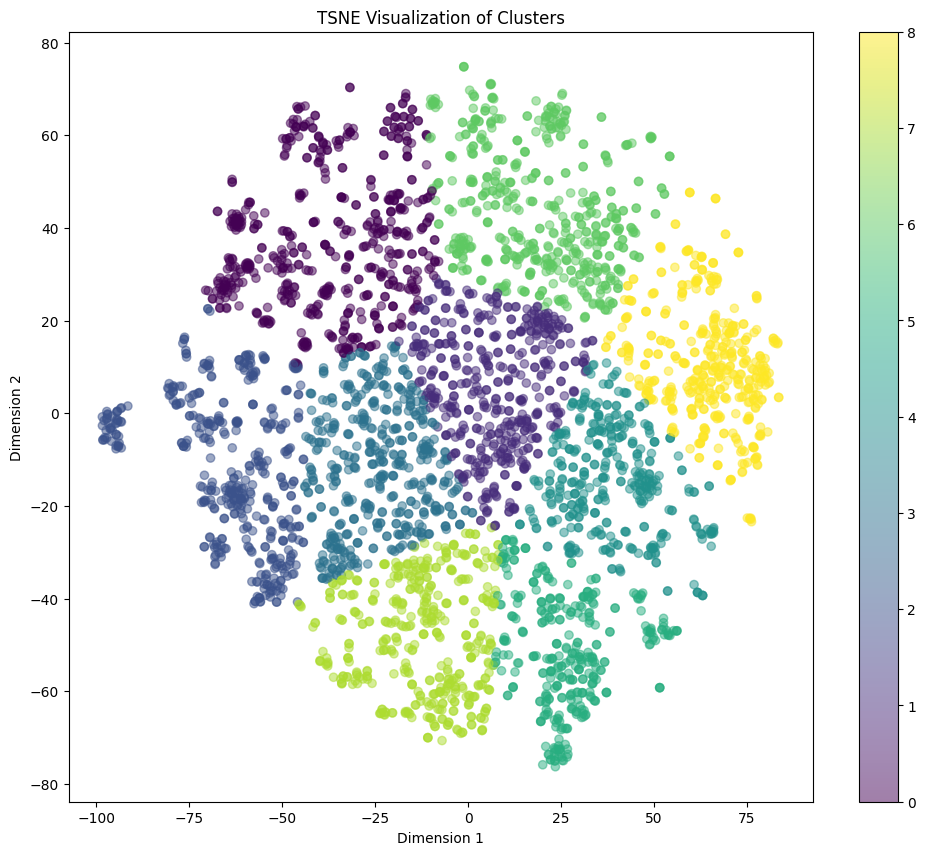

In [12]:

kmeans = KMeans(n_clusters=best_k, random_state=0)
clusters_4 = kmeans.fit_predict(best_embeddings)

unique_descriptions['clusters_4'] = clusters_4

plt.figure(figsize=(12, 10))
scatter = plt.scatter(best_embeddings[:, 0], best_embeddings[:, 1], c=clusters_4, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('TSNE Visualization of Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [13]:
cluster_distribution = unique_descriptions['clusters_4'].value_counts()
print("Cluster distribution:")
cluster_distribution

Cluster distribution:


clusters_4
0    573
6    547
1    494
3    491
8    449
7    442
2    441
4    388
5    361
Name: count, dtype: int64

In [14]:
for cluster_num in set(clusters_4):
    if cluster_num != -1:
        cluster_df = unique_descriptions[unique_descriptions['clusters_4'] == cluster_num]['Description'].value_counts()
        top_items = cluster_df[15:25]
        print(f"Cluster {cluster_num}:")
        print(top_items.index.tolist())
        # print("\n")

Cluster 0:
['Display', 'CROCHET WHITE RABBIT KEYRING', 'CROCHET BEAR RED/BLUE  KEYRING', 'IVORY WIRE KITCHEN ORGANISER', 'Thrown away.', 'BUFFALO BILL TREASURE BOOK BOX', 'GYMKHANNA TREASURE BOOK BOX', 'ABC TREASURE BOOK BOX', 'PANTRY PASTRY BRUSH', 'GYMKHANA TREASURE BOOK BOX']
Cluster 1:
['SET OF 6 HERB TINS SKETCHBOOK', 'ANTIQUE GLASS PLACE SETTING', 'DANISH ROSE BEDSIDE CABINET', 'PINK  HONEYCOMB PAPER FAN', 'CHARLIE & LOLA WASTEPAPER BIN BLUE', 'GOLD SCROLL GLASS T-LIGHT HOLDER', 'ECONOMY HOLIDAY PURSE', 'VIP HOLIDAY PURSE', 'TROPICAL HOLIDAY PURSE', 'BLOSSOM IMAGES GIFT WRAP SET']
Cluster 2:
['sold as set on dotcom and amazon', 'sold as set on dotcom', 'FOLKART CHRISTMAS TREE T-LIGHT HOLD', '36 DOILIES VINTAGE CHRISTMAS', 'reverse previous adjustment', 'incorrectly credited C550456 see 47', 'on cargo order', 'sold as set/6 by dotcom', 'Not rcvd in 10/11/2010 delivery', 'mailout']
Cluster 3:
['TEA TIME TEAPOT IN GIFT BOX', 'ENAMEL PINK TEA CONTAINER', 'SET OF 16 VINTAGE RED CUTLER

<!-- 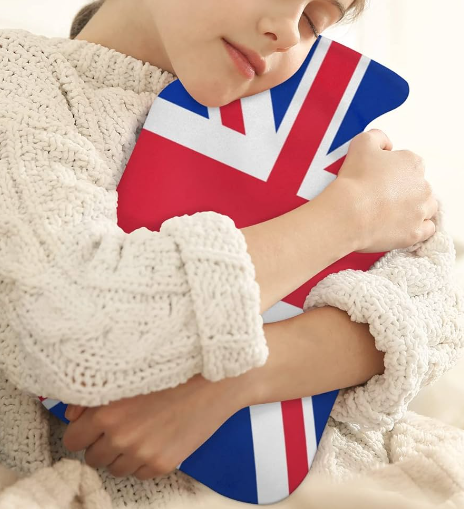 *Подпись к фото 1*  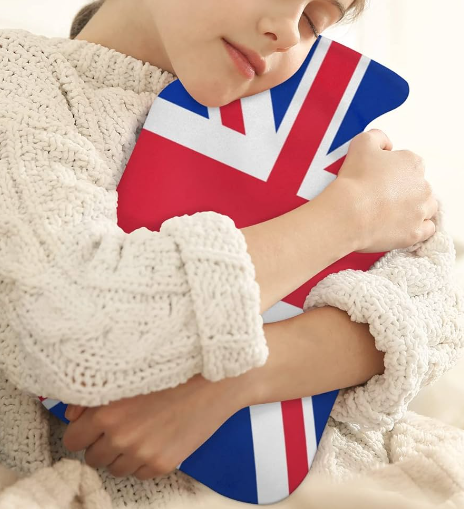 *Подпись к фото 1* -->


In [15]:
category_name = {
    0: '1. Стилизованные вещи интерьера с уникальным дизайном',
    1: '2. Стеклянные и керамические аксессуары (оформление интерьера)',
    2: '3. Часы и рождественские украшения',
    3: '4. Кухонные аксессуары и посуда',
    4: '5. Игрушки или детские товары',
    5: '6. Свечи и освещение',
    6: '7. Декор для дома',
    7: '8. Праздничные украшения',
    8: '9. Браслеты бижутерия',
}

<h3>Разбиение товаров по кластерам</h3>
<div style="display: flex; justify-content: space-around;">

  <div style="text-align: center;">
    <img src="./image/Снимок экрана 2024-09-05 230924.png" max-width="350" max-hight="150" />
    <p>1. Стилизованные вещи интерьера с уникальным дизайном</p>
  </div>

  <div style="text-align: center;">
    <img src="./image/Снимок экрана 2024-09-05 231033.png" max-width="350" max-hight="150" />
    <p>2. Стеклянные и керамические аксессуары (оформление интерьера)</p>
  </div>

  <div style="text-align: center;">
    <img src="./image/Снимок экрана 2024-09-05 231047.png" max-width="350" max-hight="150" />
    <p>3. Часы и рождественские украшения</p>
  </div>

</div>

<br>

<div style="display: flex; justify-content: space-around;">

  <div style="text-align: center;">
    <img src="./image/Снимок экрана 2024-09-05 231116.png" max-width="350" max-hight="150" />
    <p>4. Кухонные аксессуары и посуда</p>
  </div>

  <div style="text-align: center;">
    <img src="./image/Снимок экрана 2024-09-05 231128.png" max-width="350" max-hight="150" />
    <p>5. Игрушки или детские товары</p>
  </div>

  <div style="text-align: center;">
    <img src="./image/Снимок экрана 2024-09-05 231141.png" max-width="350" max-hight="150" />
    <p>6. Свечи и освещение</p>
  </div>

</div>

<br>

<div style="display: flex; justify-content: space-around;">

  <div style="text-align: center;">
    <img src="./image/Снимок экрана 2024-09-05 231153.png" max-width="350" max-hight="150" />
    <p>7. Декор для дома</p>
  </div>

  <div style="text-align: center;">
    <img src="./image/Снимок экрана 2024-09-05 231208.png" max-width="350" max-hight="150" />
    <p>8. Праздничные украшения</p>
  </div>

  <div style="text-align: center;">
    <img src="./image/Снимок экрана 2024-09-05 231218.png" max-width="350" max-hight="150" />
    <p>9. Браслеты бижутерия</p>
  </div>

</div>


In [16]:
unique_descriptions['category_name'] = unique_descriptions.clusters_4.apply(lambda x : category_name.get(x, 'other'))

In [17]:
unique_descriptions[15:25]

Description  clusters_4  \
15    BOX OF VINTAGE JIGSAW BLOCKS           0   
16  BOX OF VINTAGE ALPHABET BLOCKS           0   
17        HOME BUILDING BLOCK WORD           0   
18        LOVE BUILDING BLOCK WORD           0   
19     RECIPE BOX WITH METAL HEART           6   
20             DOORMAT NEW ENGLAND           0   
21        JAM MAKING SET WITH JARS           3   
22     RED COAT RACK PARIS FASHION           8   
23  YELLOW COAT RACK PARIS FASHION           8   
24    BLUE COAT RACK PARIS FASHION           8   

                                        category_name  
15  1. Стилизованные вещи интерьера с уникальным д...  
16  1. Стилизованные вещи интерьера с уникальным д...  
17  1. Стилизованные вещи интерьера с уникальным д...  
18  1. Стилизованные вещи интерьера с уникальным д...  
19                                  7. Декор для дома  
20  1. Стилизованные вещи интерьера с уникальным д...  
21                    4. Кухонные аксессуары и посуда  
22                              9. Браслеты бижутерия  
23                              9. Браслеты бижутерия  
24                              9. Браслеты бижутерия

перевод 50 товарных позиций для каждой категории для оценки семантического сходства товарных позиций в категориях (25-30% от общего кол. в каждой категории)

## Подготовка данных для анализа временных рядов и предсказания продаж

In [18]:
df_with_category = df.merge(unique_descriptions, how='left')
df_with_category['category_name'].fillna('11. Прочие', inplace=True)
df_with_category['clusters_4'].fillna('11', inplace=True)
# Добавление столбца с номером недели года и месяца
df_with_category['Week'] = df_with_category['InvoiceDate'].dt.isocalendar().week
df_with_category['Month'] = df_with_category['InvoiceDate'].dt.month
df_with_category['Year'] = df_with_category['InvoiceDate'].dt.year

In [19]:
df_with_category

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         9   
1         536365     71053                  WHITE METAL LANTERN        10   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         9   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         7   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         9   
...          ...       ...                                  ...       ...   
966418    581019    84251G     GREETING CARD, OVERCROWDED POOL.         6   
966419    581439    17084P                DRAGONS BLOOD INCENSE         9   
966420    580744     22899          CHILDREN'S APRON DOLLY GIRL        23   
966421    580730     21288      STRIPEY CHOCOLATE NESTING BOXES         6   
966422    580730     21137             BLACK RECORD COVER FRAME         8   

               InvoiceDate  UnitPrice  CustomerID         Country  Return  \
0      2010-12-01 08:26:00       2.55       17850  United Kingdom       0   
1      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
2      2010-12-01 08:26:00       2.75       17850  United Kingdom       0   
3      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
4      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
...                    ...        ...         ...             ...     ...   
966418 2012-12-07 10:11:00       0.19       14794  United Kingdom       0   
966419 2012-12-08 16:30:00       0.42     -999999  United Kingdom       0   
966420 2012-12-06 09:31:00       1.85       13694  United Kingdom       0   
966421 2012-12-05 17:28:00       3.29     -999999  United Kingdom       0   
966422 2012-12-05 17:28:00       4.13     -999999  United Kingdom       0   

       clusters_4                       category_name  Week  Month  Year  
0             6.0                   7. Декор для дома    48     12  2010  
1             5.0                6. Свечи и освещение    48     12  2010  
2             6.0                   7. Декор для дома    48     12  2010  
3             6.0                   7. Декор для дома    48     12  2010  
4             6.0                   7. Декор для дома    48     12  2010  
...           ...                                 ...   ...    ...   ...  
966418        2.0  3. Часы и рождественские украшения    49     12  2012  
966419        5.0                6. Свечи и освещение    49     12  2012  
966420        7.0            8. Праздничные украшения    49     12  2012  
966421        7.0            8. Праздничные украшения    49     12  2012  
966422        6.0                   7. Декор для дома    49     12  2012  

[966423 rows x 14 columns]

## Аналитика временных рядов продаж категорий товаров

Построение и визуализация продаж по категориям:

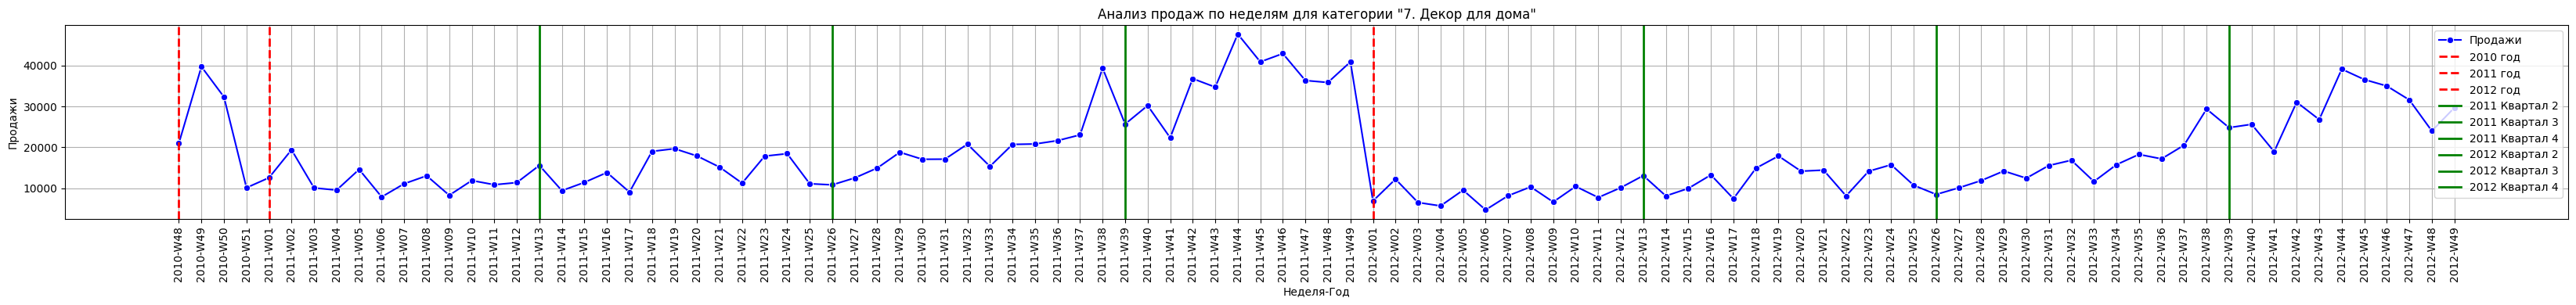

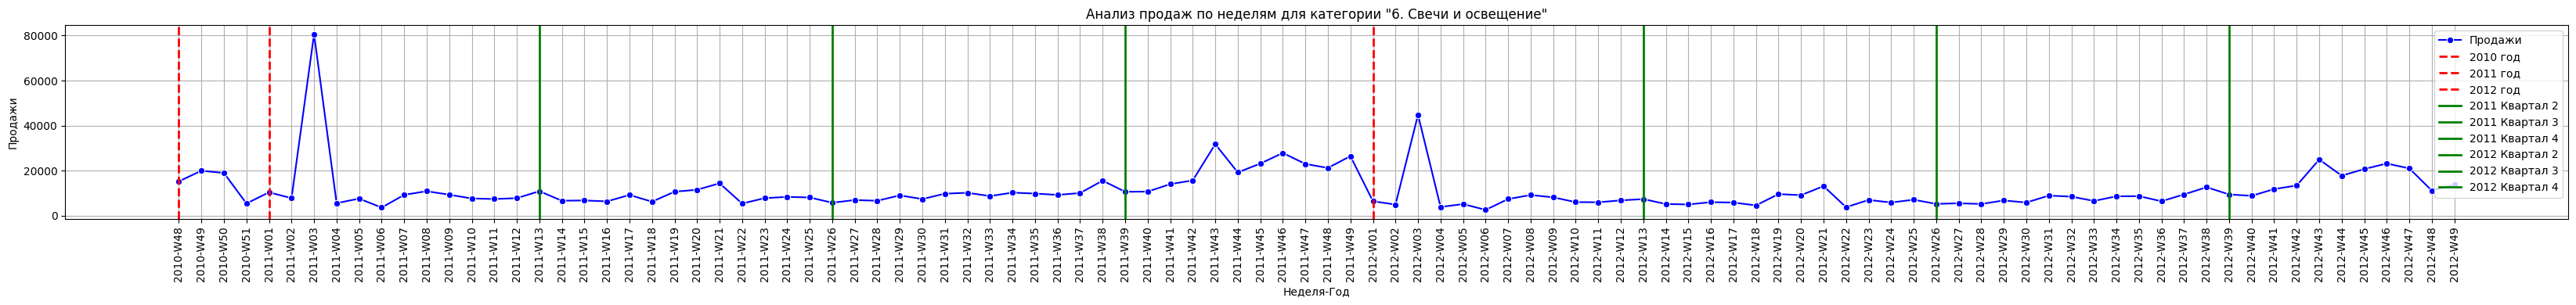

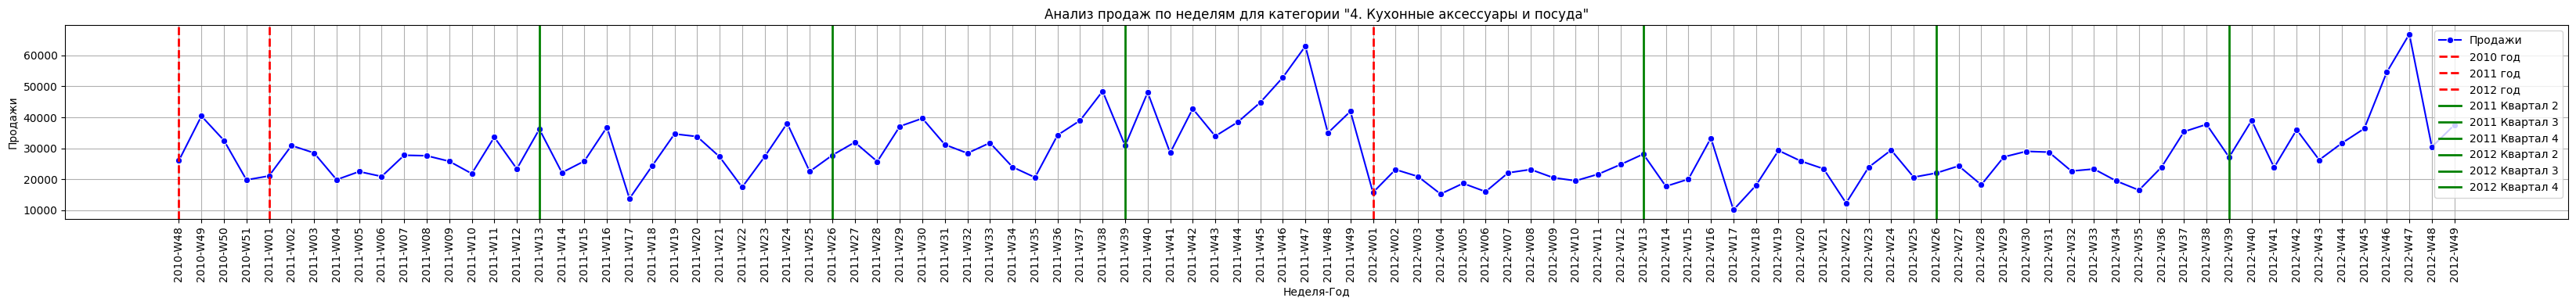

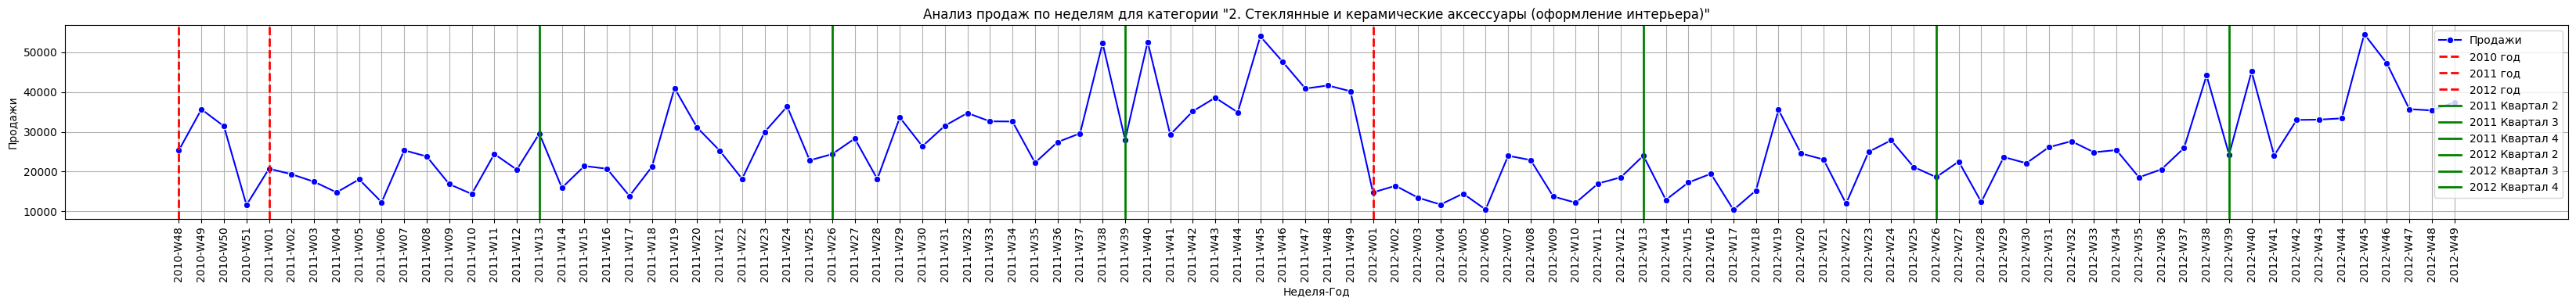

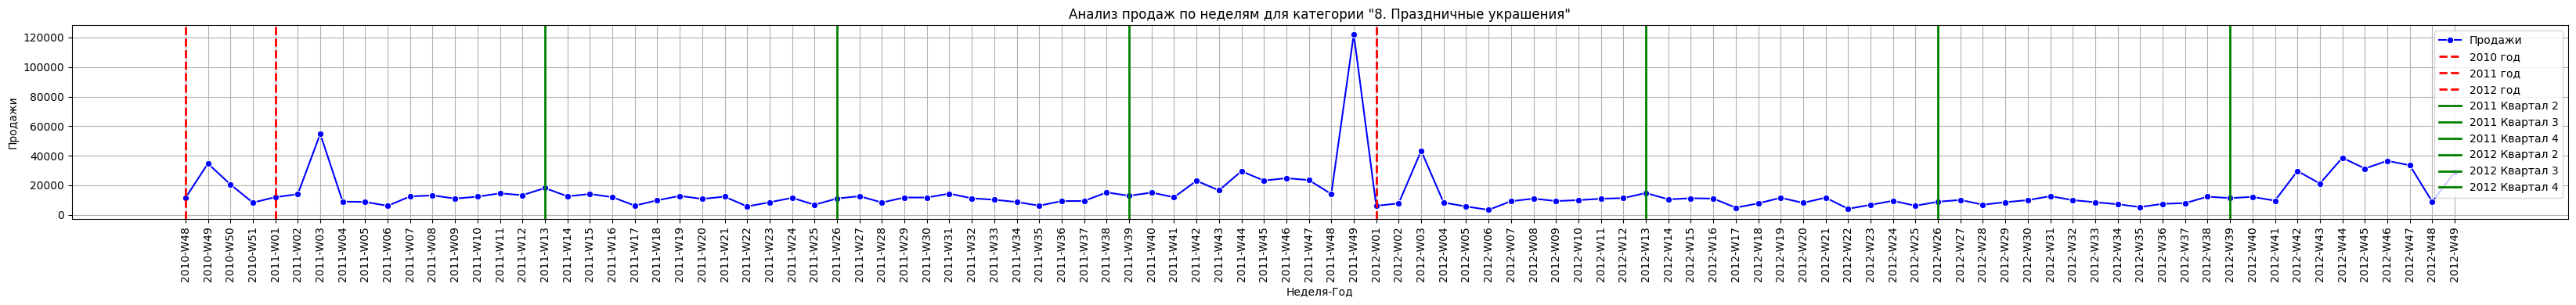

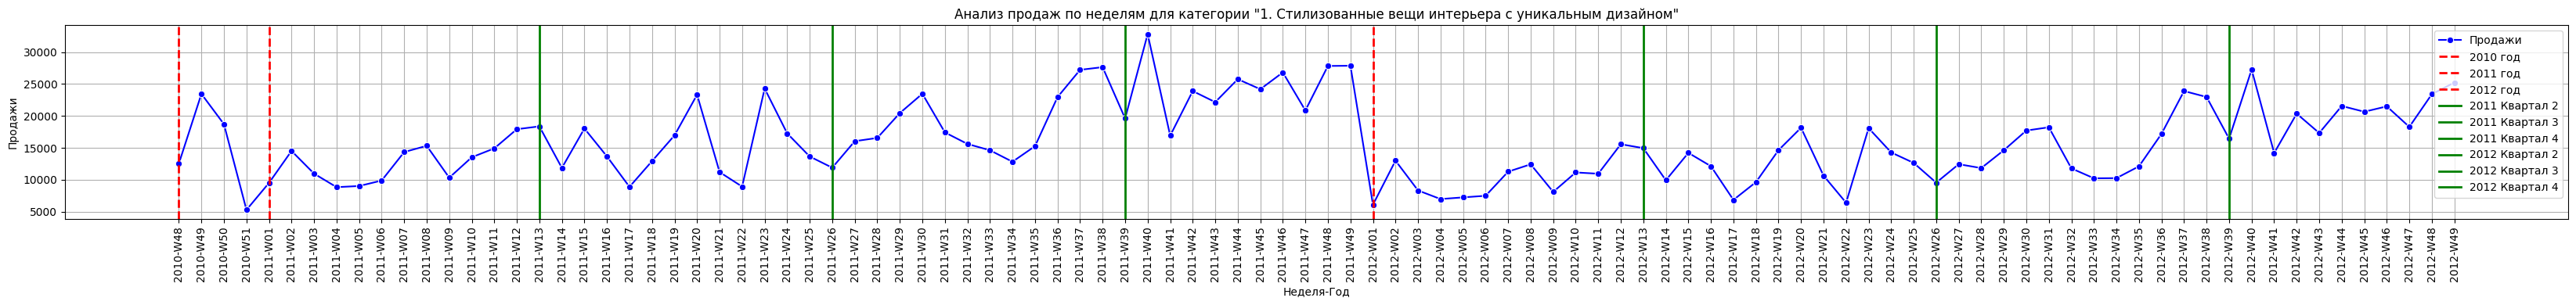

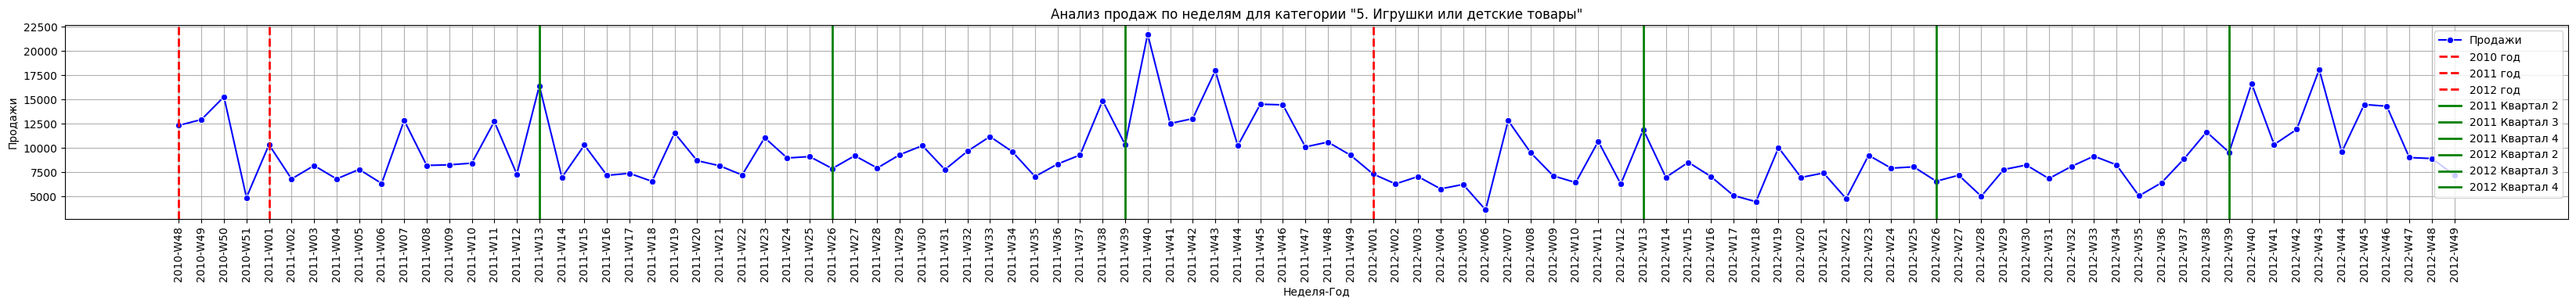

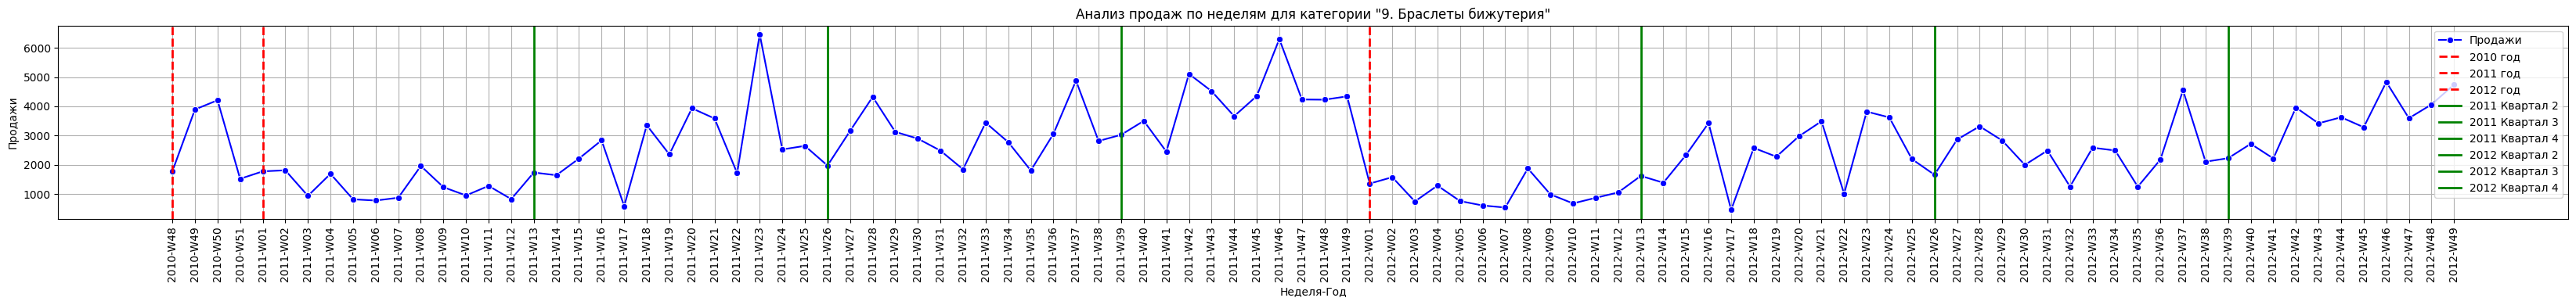

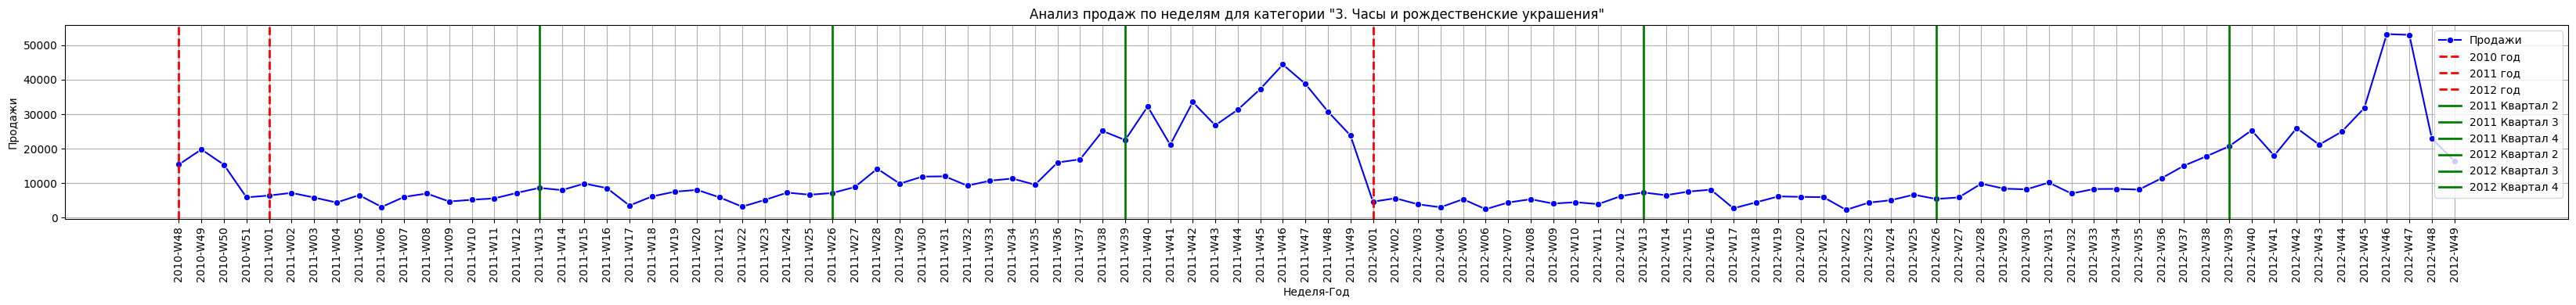

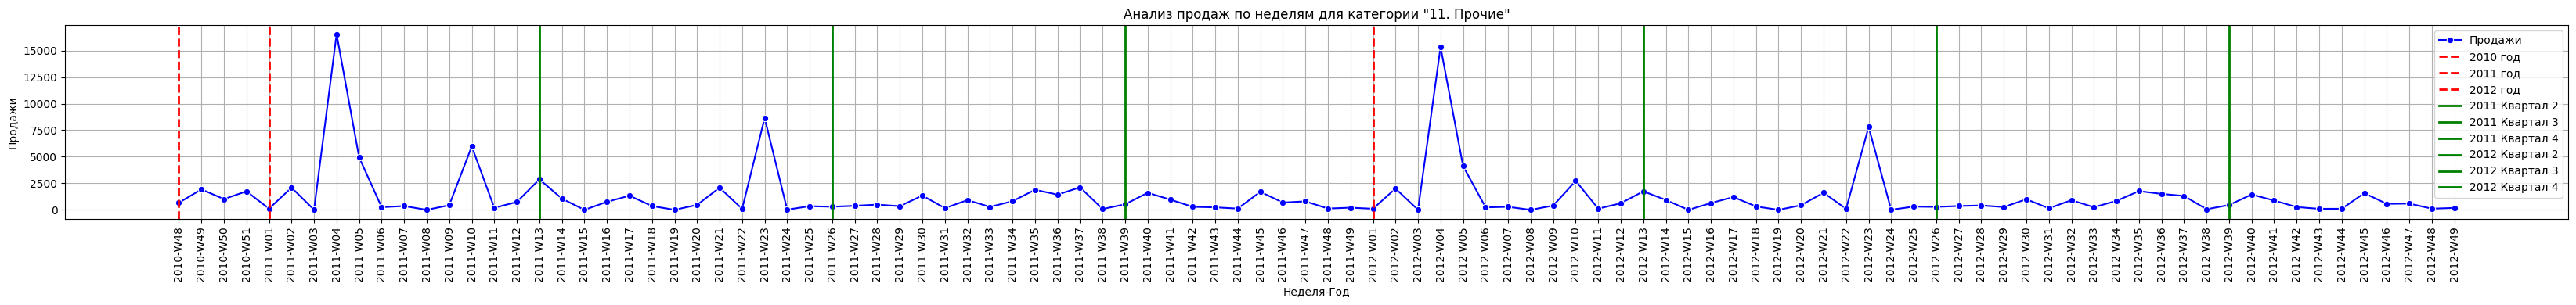

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_category_sales(df, category_name):
    data_category = df[df['category_name'] == category_name]
    sales_by_week_year = data_category.groupby(['Year', 'Week'])['Quantity'].sum().reset_index()
    
    sales_by_week_year['Year_Week'] = sales_by_week_year.apply(
        lambda row: f"{int(row['Year'])}-W{int(row['Week']):02d}", axis=1
    )
    
    fig, ax = plt.subplots(figsize=(33, 4))
    
    sns.lineplot(x='Year_Week', y='Quantity', data=sales_by_week_year, marker='o', ax=ax, label='Продажи', color='blue')
    
    ax.set_title(f'Анализ продаж по неделям для категории "{category_name}"')
    ax.set_xlabel('Неделя-Год')
    ax.set_ylabel('Продажи')
    
    ax.set_xticks(sales_by_week_year['Year_Week'])
    ax.set_xticklabels(sales_by_week_year['Year_Week'], rotation=90)

    years = sales_by_week_year['Year'].unique()
    for year in years:
        year_weeks = sales_by_week_year[sales_by_week_year['Year'] == year]['Year_Week']
        ax.axvline(x=year_weeks.iloc[0], color='red', linestyle='--', linewidth=2, label=f'{year} год')

    for year in years:
        quarters = [13, 26, 39, 52] 
        for week in quarters:
            week_label = f"{int(year)}-W{week:02d}"
            if week_label in sales_by_week_year['Year_Week'].values:
                ax.axvline(x=week_label, color='green', linestyle='-', linewidth=2, label=f'{year} Квартал {week//13 + 1}')
    
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

categories = df_with_category['category_name'].unique()
for category in categories:
    plot_category_sales(df_with_category, category)

In [21]:
df_with_category

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         9   
1         536365     71053                  WHITE METAL LANTERN        10   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         9   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         7   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         9   
...          ...       ...                                  ...       ...   
966418    581019    84251G     GREETING CARD, OVERCROWDED POOL.         6   
966419    581439    17084P                DRAGONS BLOOD INCENSE         9   
966420    580744     22899          CHILDREN'S APRON DOLLY GIRL        23   
966421    580730     21288      STRIPEY CHOCOLATE NESTING BOXES         6   
966422    580730     21137             BLACK RECORD COVER FRAME         8   

               InvoiceDate  UnitPrice  CustomerID         Country  Return  \
0      2010-12-01 08:26:00       2.55       17850  United Kingdom       0   
1      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
2      2010-12-01 08:26:00       2.75       17850  United Kingdom       0   
3      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
4      2010-12-01 08:26:00       3.39       17850  United Kingdom       0   
...                    ...        ...         ...             ...     ...   
966418 2012-12-07 10:11:00       0.19       14794  United Kingdom       0   
966419 2012-12-08 16:30:00       0.42     -999999  United Kingdom       0   
966420 2012-12-06 09:31:00       1.85       13694  United Kingdom       0   
966421 2012-12-05 17:28:00       3.29     -999999  United Kingdom       0   
966422 2012-12-05 17:28:00       4.13     -999999  United Kingdom       0   

       clusters_4                       category_name  Week  Month  Year  
0             6.0                   7. Декор для дома    48     12  2010  
1             5.0                6. Свечи и освещение    48     12  2010  
2             6.0                   7. Декор для дома    48     12  2010  
3             6.0                   7. Декор для дома    48     12  2010  
4             6.0                   7. Декор для дома    48     12  2010  
...           ...                                 ...   ...    ...   ...  
966418        2.0  3. Часы и рождественские украшения    49     12  2012  
966419        5.0                6. Свечи и освещение    49     12  2012  
966420        7.0            8. Праздничные украшения    49     12  2012  
966421        7.0            8. Праздничные украшения    49     12  2012  
966422        6.0                   7. Декор для дома    49     12  2012  

[966423 rows x 14 columns]

Importing plotly failed. Interactive plots will not work.




Категория: 7. Декор для дома


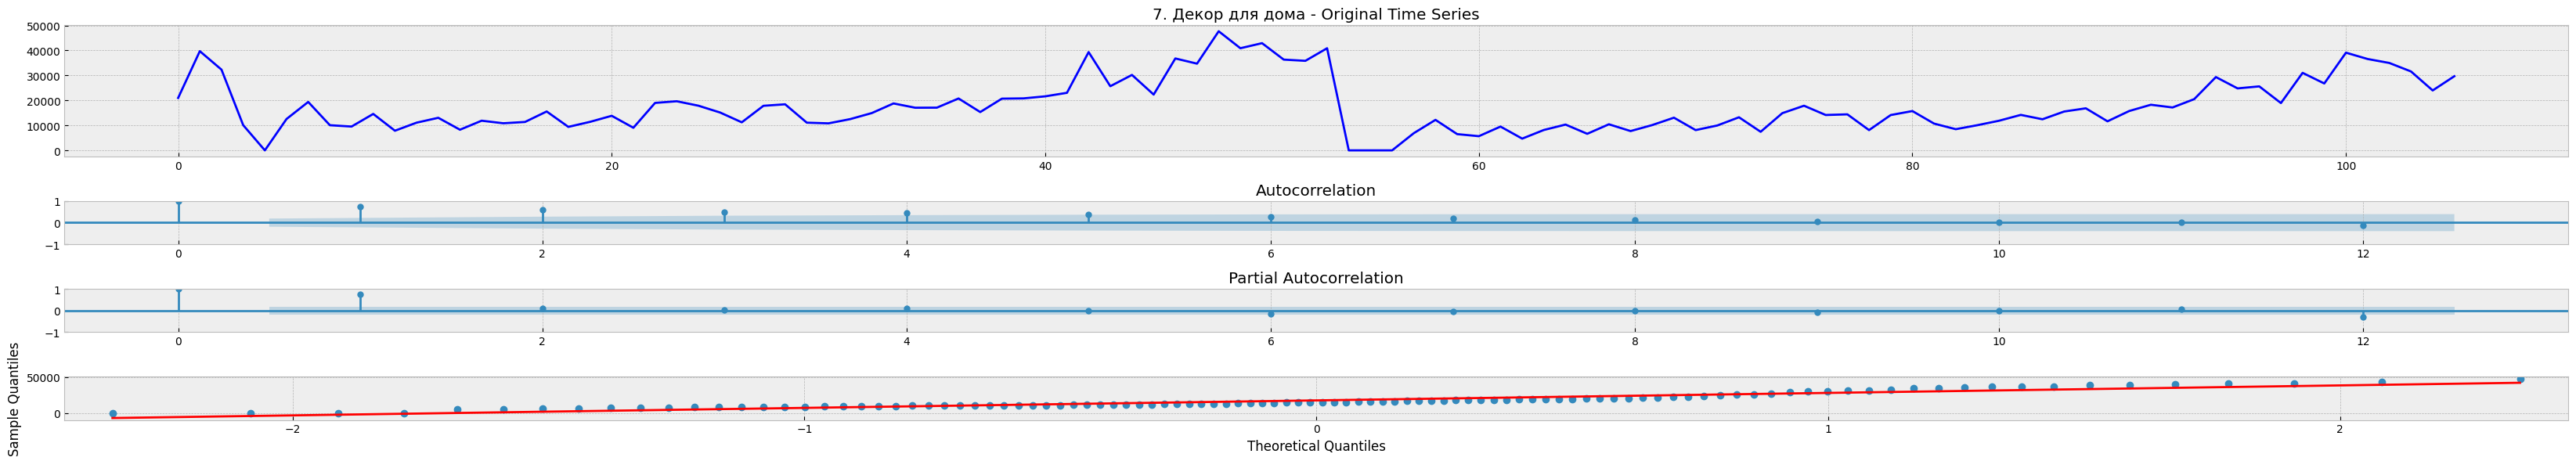

21:57:23 - cmdstanpy - INFO - Chain [1] start processing


Baseline MSE: 1.89e+07, MAE: 3.34e+03, R²: 0.685


21:57:24 - cmdstanpy - INFO - Chain [1] done processing
21:57:24 - cmdstanpy - INFO - Chain [1] start processing
21:57:24 - cmdstanpy - INFO - Chain [1] done processing
21:57:24 - cmdstanpy - INFO - Chain [1] start processing
21:57:24 - cmdstanpy - INFO - Chain [1] done processing
21:57:24 - cmdstanpy - INFO - Chain [1] start processing
21:57:25 - cmdstanpy - INFO - Chain [1] done processing
21:57:25 - cmdstanpy - INFO - Chain [1] start processing


Fold 1: MSE = 3.48e+11, MAE = 5.10e+05, R² = -23016.344
Fold 2: MSE = 3.47e+10, MAE = 1.14e+05, R² = -126.870
Fold 3: MSE = 1.42e+07, MAE = 3.18e+03, R² = -0.472
Fold 4: MSE = 1.15e+07, MAE = 2.67e+03, R² = 0.834


21:57:25 - cmdstanpy - INFO - Chain [1] done processing
21:57:25 - cmdstanpy - INFO - Chain [1] start processing
21:57:25 - cmdstanpy - INFO - Chain [1] done processing
21:57:26 - cmdstanpy - INFO - Chain [1] start processing
21:57:26 - cmdstanpy - INFO - Chain [1] done processing
21:57:26 - cmdstanpy - INFO - Chain [1] start processing
21:57:26 - cmdstanpy - INFO - Chain [1] done processing
21:57:26 - cmdstanpy - INFO - Chain [1] start processing
21:57:27 - cmdstanpy - INFO - Chain [1] done processing
21:57:27 - cmdstanpy - INFO - Chain [1] start processing
21:57:27 - cmdstanpy - INFO - Chain [1] done processing
21:57:27 - cmdstanpy - INFO - Chain [1] start processing
21:57:28 - cmdstanpy - INFO - Chain [1] done processing
21:57:28 - cmdstanpy - INFO - Chain [1] start processing
21:57:28 - cmdstanpy - INFO - Chain [1] done processing
21:57:28 - cmdstanpy - INFO - Chain [1] start processing
21:57:28 - cmdstanpy - INFO - Chain [1] done processing
21:57:28 - cmdstanpy - INFO - Chain [1] 

Best Prophet parameters: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'interval_width': 0.7}


21:57:33 - cmdstanpy - INFO - Chain [1] done processing


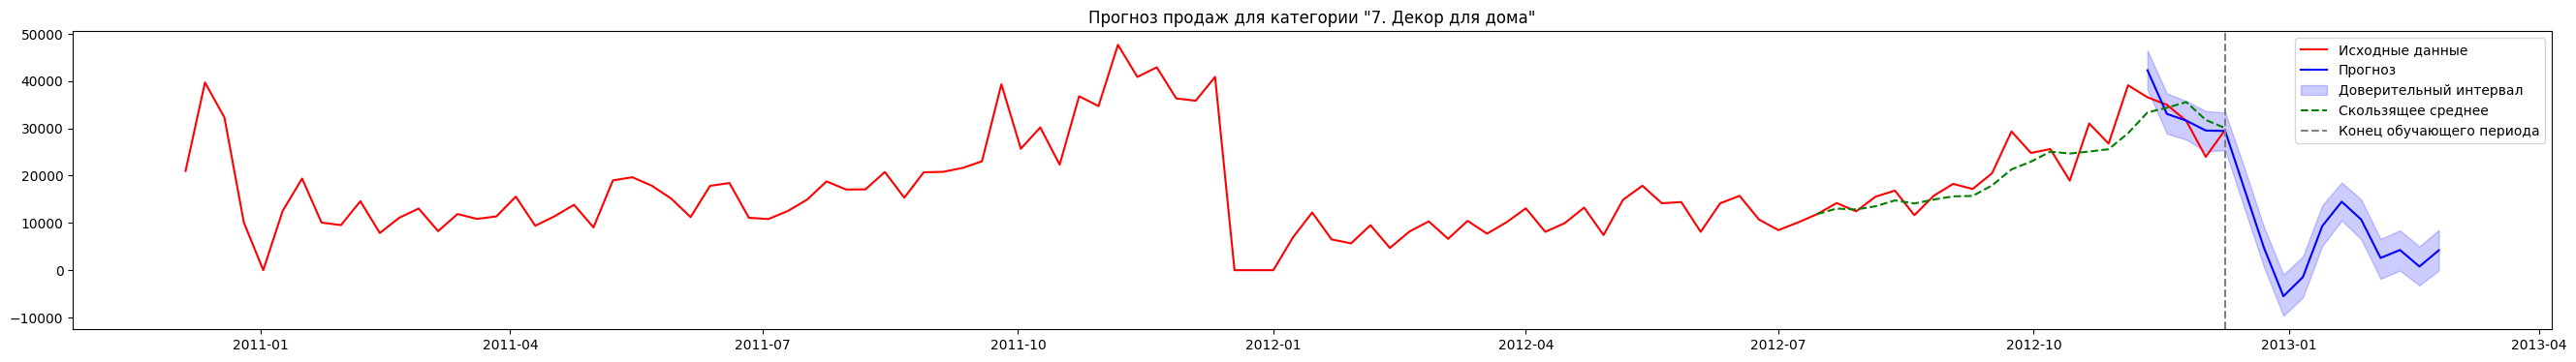

Prophet Model - MSE: 1.85e+07, MAE: 3.32e+03, R²: 0.730


Категория: 6. Свечи и освещение


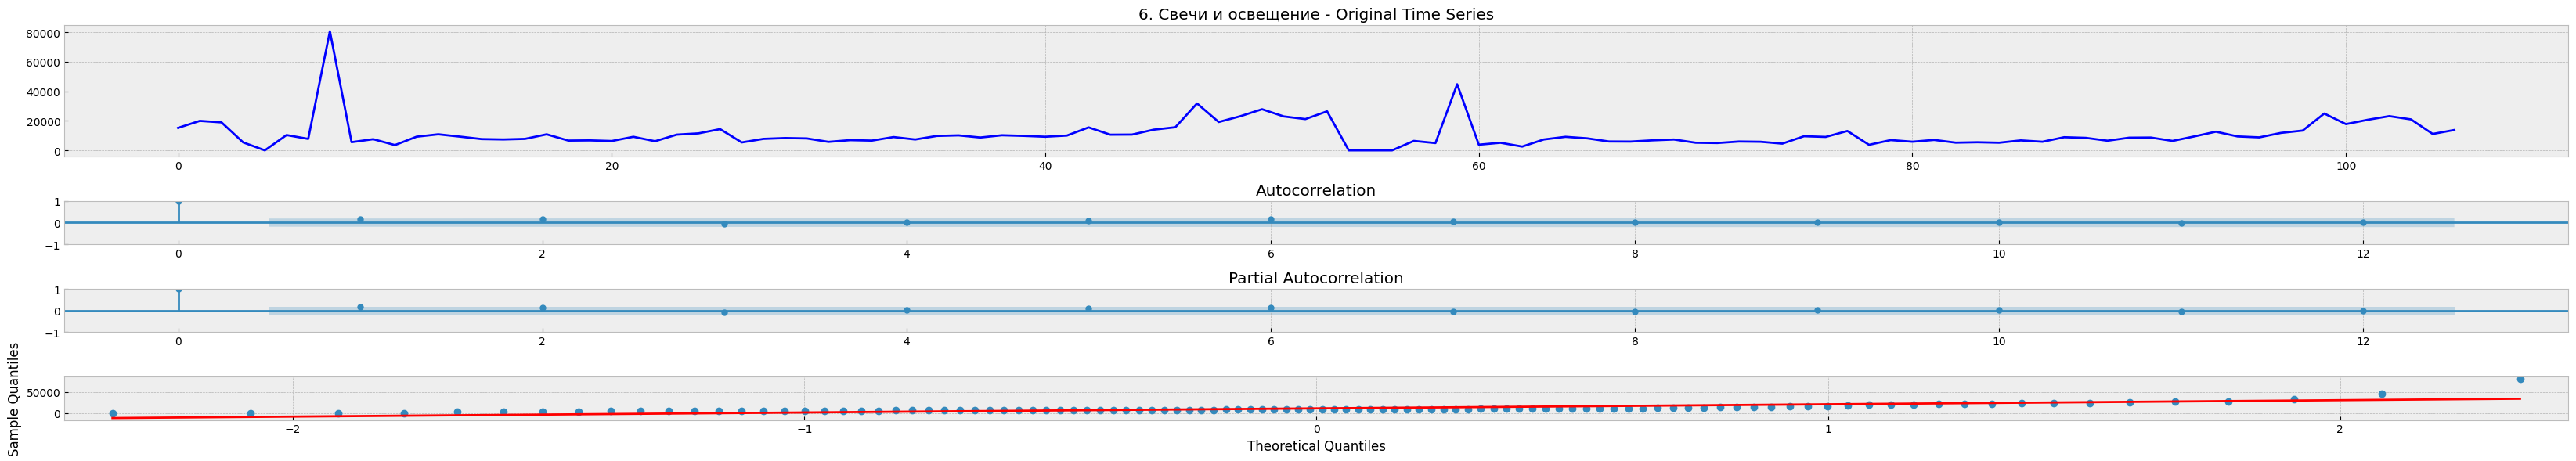

21:57:33 - cmdstanpy - INFO - Chain [1] start processing


Baseline MSE: 1.13e+07, MAE: 2.19e+03, R²: 0.644


21:57:33 - cmdstanpy - INFO - Chain [1] done processing
21:57:34 - cmdstanpy - INFO - Chain [1] start processing
21:57:34 - cmdstanpy - INFO - Chain [1] done processing
21:57:34 - cmdstanpy - INFO - Chain [1] start processing
21:57:34 - cmdstanpy - INFO - Chain [1] done processing
21:57:34 - cmdstanpy - INFO - Chain [1] start processing
21:57:34 - cmdstanpy - INFO - Chain [1] done processing
21:57:34 - cmdstanpy - INFO - Chain [1] start processing


Fold 1: MSE = 8.37e+10, MAE = 2.42e+05, R² = -19668.782
Fold 2: MSE = 2.88e+11, MAE = 3.10e+05, R² = -2078.125
Fold 3: MSE = 2.22e+07, MAE = 3.98e+03, R² = -4.227
Fold 4: MSE = 1.01e+07, MAE = 2.38e+03, R² = 0.707


21:57:35 - cmdstanpy - INFO - Chain [1] done processing
21:57:35 - cmdstanpy - INFO - Chain [1] start processing
21:57:35 - cmdstanpy - INFO - Chain [1] done processing
21:57:35 - cmdstanpy - INFO - Chain [1] start processing
21:57:35 - cmdstanpy - INFO - Chain [1] done processing
21:57:35 - cmdstanpy - INFO - Chain [1] start processing
21:57:35 - cmdstanpy - INFO - Chain [1] done processing
21:57:36 - cmdstanpy - INFO - Chain [1] start processing
21:57:36 - cmdstanpy - INFO - Chain [1] done processing
21:57:36 - cmdstanpy - INFO - Chain [1] start processing
21:57:36 - cmdstanpy - INFO - Chain [1] done processing
21:57:36 - cmdstanpy - INFO - Chain [1] start processing
21:57:36 - cmdstanpy - INFO - Chain [1] done processing
21:57:36 - cmdstanpy - INFO - Chain [1] start processing
21:57:37 - cmdstanpy - INFO - Chain [1] done processing
21:57:37 - cmdstanpy - INFO - Chain [1] start processing
21:57:37 - cmdstanpy - INFO - Chain [1] done processing
21:57:37 - cmdstanpy - INFO - Chain [1] 

Best Prophet parameters: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'interval_width': 0.7}


21:57:41 - cmdstanpy - INFO - Chain [1] done processing


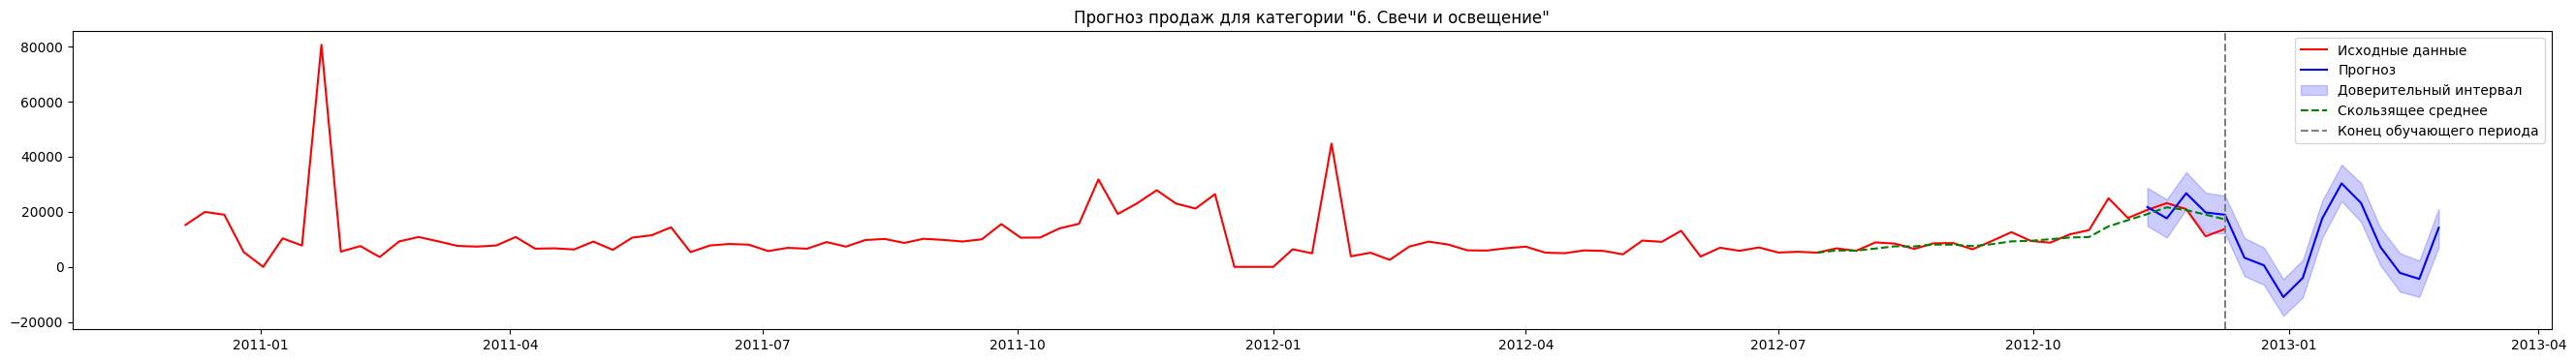

Prophet Model - MSE: 2.25e+07, MAE: 3.96e+03, R²: 0.321


Категория: 4. Кухонные аксессуары и посуда


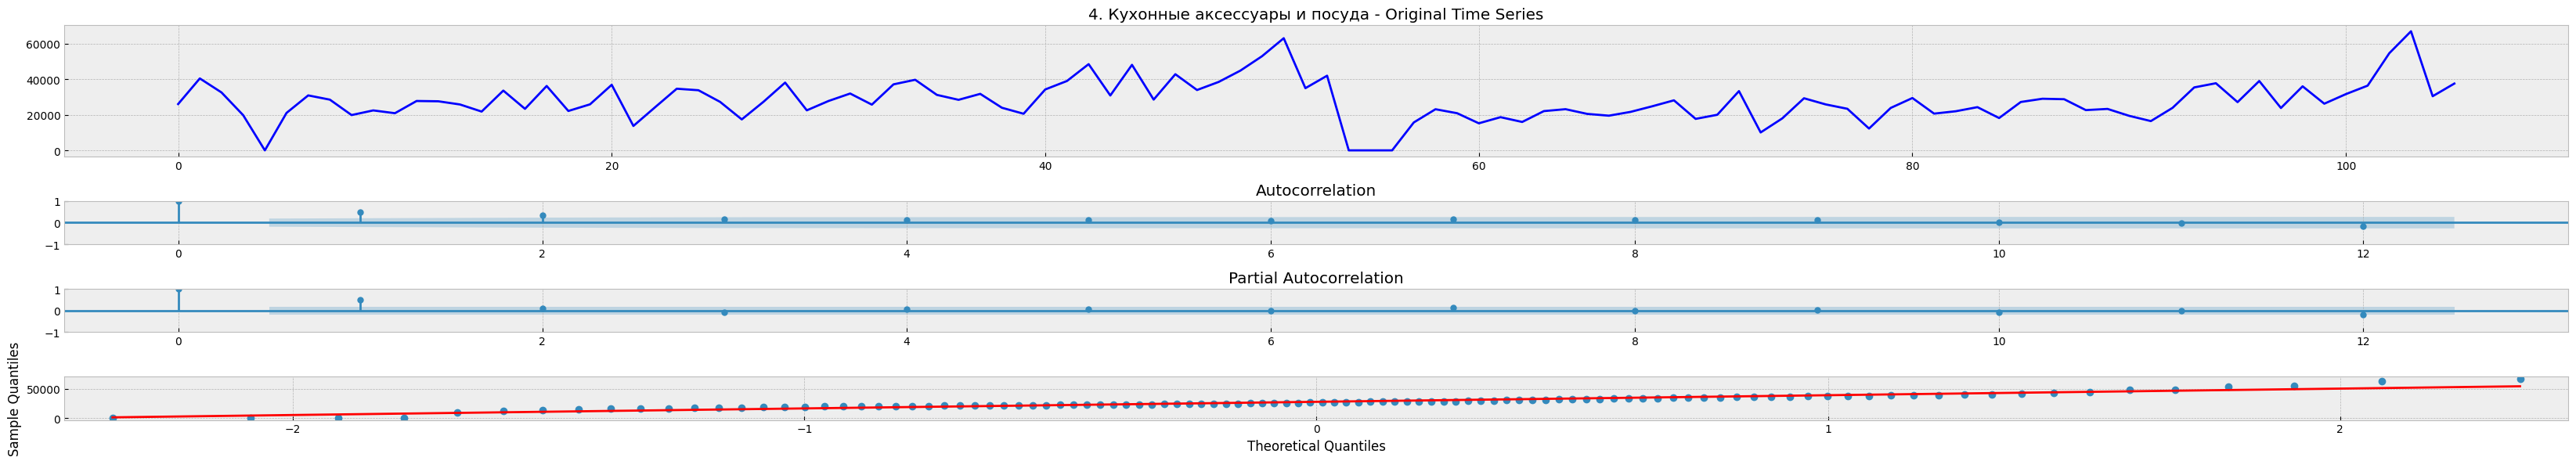

21:57:42 - cmdstanpy - INFO - Chain [1] start processing
21:57:42 - cmdstanpy - INFO - Chain [1] done processing


Baseline MSE: 8.00e+07, MAE: 7.22e+03, R²: 0.427


21:57:42 - cmdstanpy - INFO - Chain [1] start processing
21:57:42 - cmdstanpy - INFO - Chain [1] done processing
21:57:42 - cmdstanpy - INFO - Chain [1] start processing
21:57:42 - cmdstanpy - INFO - Chain [1] done processing
21:57:42 - cmdstanpy - INFO - Chain [1] start processing
21:57:42 - cmdstanpy - INFO - Chain [1] done processing
21:57:43 - cmdstanpy - INFO - Chain [1] start processing


Fold 1: MSE = 3.04e+10, MAE = 1.45e+05, R² = -628.377
Fold 2: MSE = 7.84e+09, MAE = 5.56e+04, R² = -24.354
Fold 3: MSE = 2.77e+07, MAE = 3.93e+03, R² = 0.015
Fold 4: MSE = 4.72e+07, MAE = 5.17e+03, R² = 0.650


21:57:43 - cmdstanpy - INFO - Chain [1] done processing
21:57:43 - cmdstanpy - INFO - Chain [1] start processing
21:57:43 - cmdstanpy - INFO - Chain [1] done processing
21:57:43 - cmdstanpy - INFO - Chain [1] start processing
21:57:44 - cmdstanpy - INFO - Chain [1] done processing
21:57:44 - cmdstanpy - INFO - Chain [1] start processing
21:57:44 - cmdstanpy - INFO - Chain [1] done processing
21:57:44 - cmdstanpy - INFO - Chain [1] start processing
21:57:44 - cmdstanpy - INFO - Chain [1] done processing
21:57:44 - cmdstanpy - INFO - Chain [1] start processing
21:57:44 - cmdstanpy - INFO - Chain [1] done processing
21:57:44 - cmdstanpy - INFO - Chain [1] start processing
21:57:45 - cmdstanpy - INFO - Chain [1] done processing
21:57:45 - cmdstanpy - INFO - Chain [1] start processing
21:57:45 - cmdstanpy - INFO - Chain [1] done processing
21:57:45 - cmdstanpy - INFO - Chain [1] start processing
21:57:45 - cmdstanpy - INFO - Chain [1] done processing
21:57:45 - cmdstanpy - INFO - Chain [1] 

Best Prophet parameters: {'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'interval_width': 0.7}


21:57:49 - cmdstanpy - INFO - Chain [1] done processing


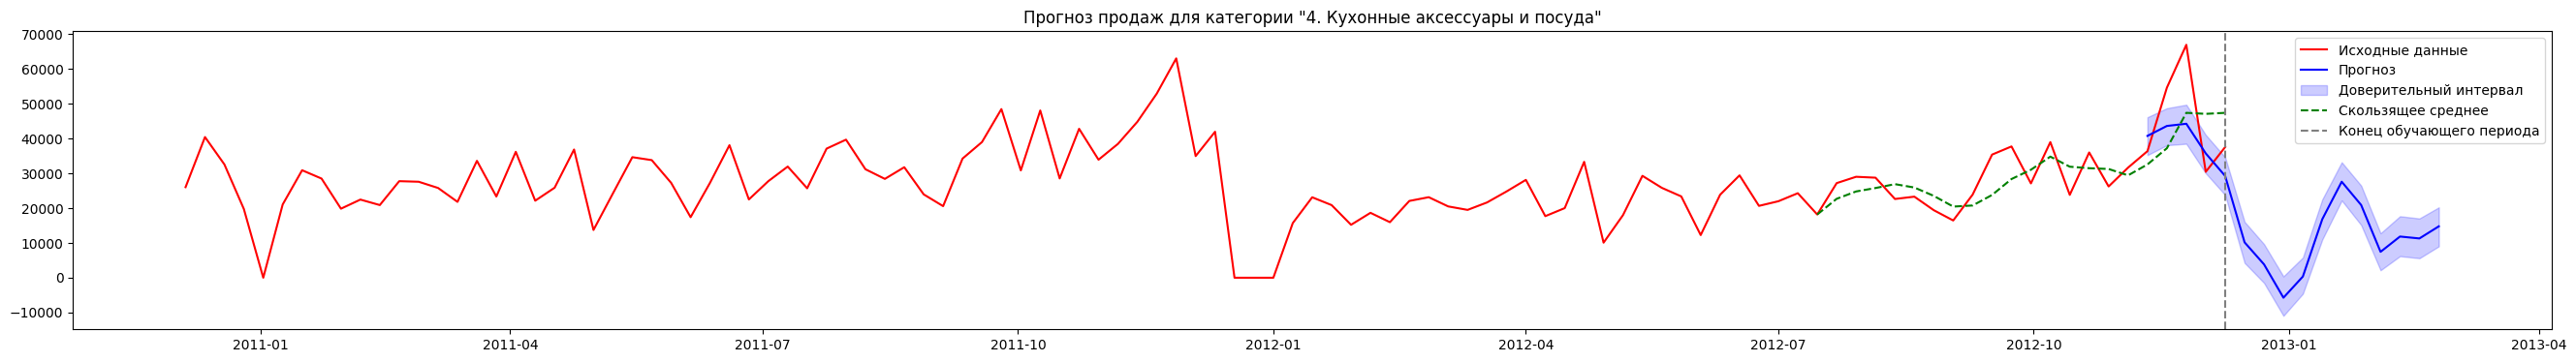

Prophet Model - MSE: 6.59e+07, MAE: 6.48e+03, R²: 0.495


Категория: 2. Стеклянные и керамические аксессуары (оформление интерьера)


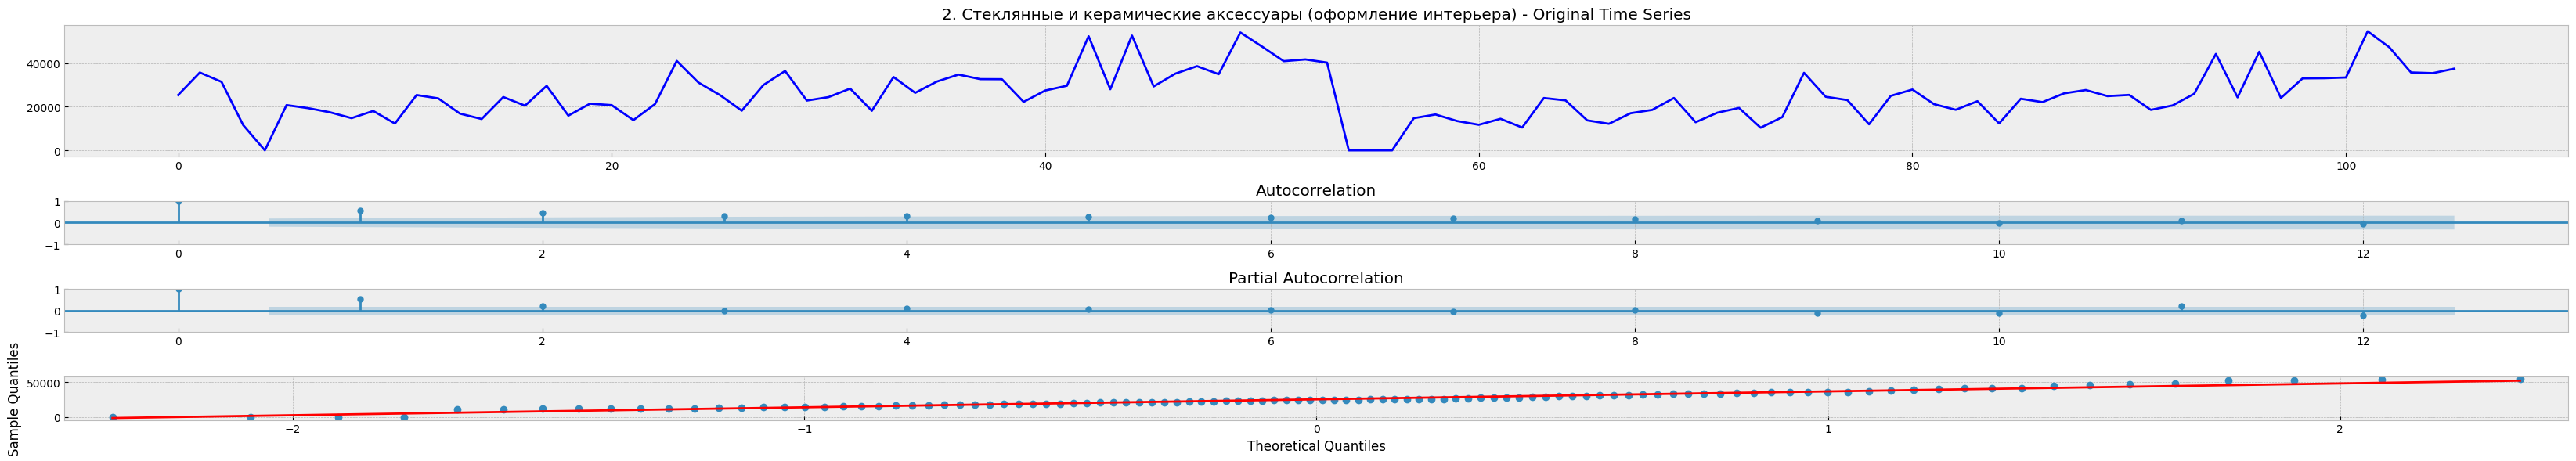

21:57:50 - cmdstanpy - INFO - Chain [1] start processing
21:57:50 - cmdstanpy - INFO - Chain [1] done processing


Baseline MSE: 5.28e+07, MAE: 5.45e+03, R²: 0.422


21:57:50 - cmdstanpy - INFO - Chain [1] start processing
21:57:50 - cmdstanpy - INFO - Chain [1] done processing
21:57:50 - cmdstanpy - INFO - Chain [1] start processing
21:57:51 - cmdstanpy - INFO - Chain [1] done processing
21:57:51 - cmdstanpy - INFO - Chain [1] start processing
21:57:51 - cmdstanpy - INFO - Chain [1] done processing
21:57:51 - cmdstanpy - INFO - Chain [1] start processing


Fold 1: MSE = 8.77e+10, MAE = 2.48e+05, R² = -2029.280
Fold 2: MSE = 2.53e+10, MAE = 9.65e+04, R² = -79.723
Fold 3: MSE = 2.37e+07, MAE = 4.03e+03, R² = 0.343
Fold 4: MSE = 3.76e+07, MAE = 4.71e+03, R² = 0.643


21:57:51 - cmdstanpy - INFO - Chain [1] done processing
21:57:52 - cmdstanpy - INFO - Chain [1] start processing
21:57:52 - cmdstanpy - INFO - Chain [1] done processing
21:57:52 - cmdstanpy - INFO - Chain [1] start processing
21:57:52 - cmdstanpy - INFO - Chain [1] done processing
21:57:52 - cmdstanpy - INFO - Chain [1] start processing
21:57:53 - cmdstanpy - INFO - Chain [1] done processing
21:57:53 - cmdstanpy - INFO - Chain [1] start processing
21:57:53 - cmdstanpy - INFO - Chain [1] done processing
21:57:53 - cmdstanpy - INFO - Chain [1] start processing
21:57:54 - cmdstanpy - INFO - Chain [1] done processing
21:57:54 - cmdstanpy - INFO - Chain [1] start processing
21:57:54 - cmdstanpy - INFO - Chain [1] done processing
21:57:54 - cmdstanpy - INFO - Chain [1] start processing
21:57:54 - cmdstanpy - INFO - Chain [1] done processing
21:57:54 - cmdstanpy - INFO - Chain [1] start processing
21:57:55 - cmdstanpy - INFO - Chain [1] done processing
21:57:55 - cmdstanpy - INFO - Chain [1] 

Best Prophet parameters: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'interval_width': 0.7}


21:57:58 - cmdstanpy - INFO - Chain [1] done processing


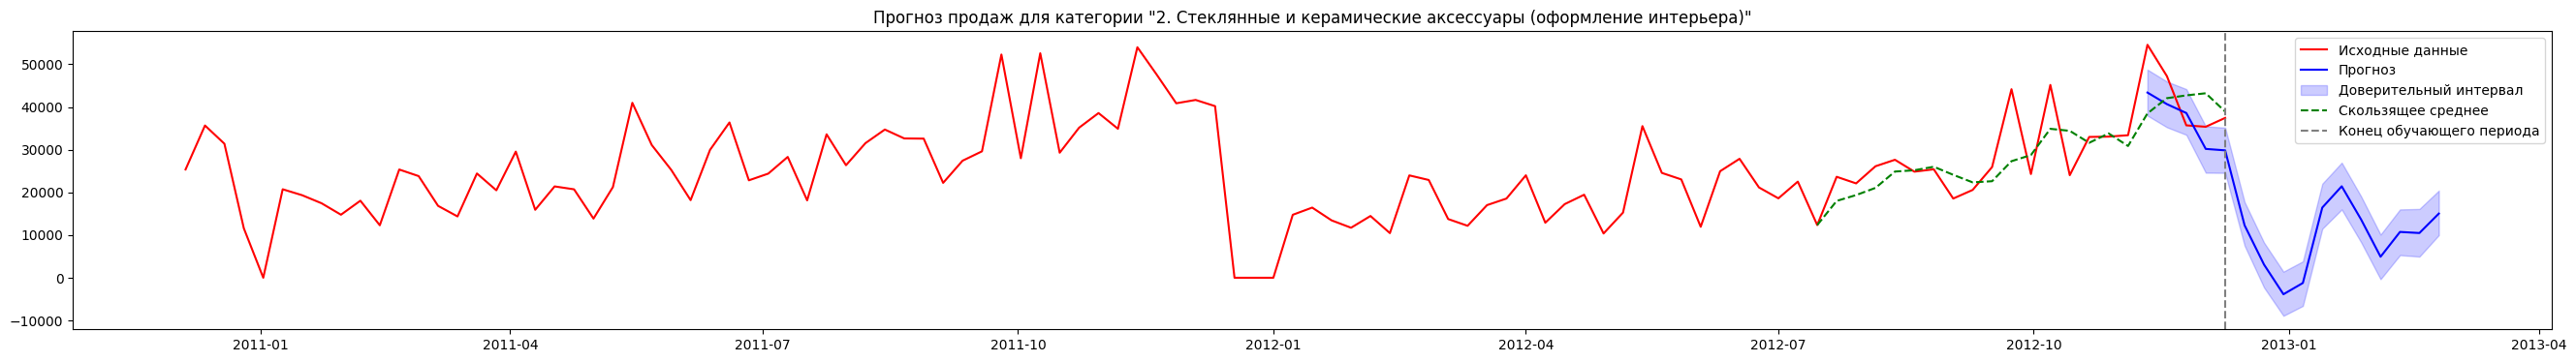

Prophet Model - MSE: 5.36e+07, MAE: 6.08e+03, R²: 0.477


Категория: 8. Праздничные украшения


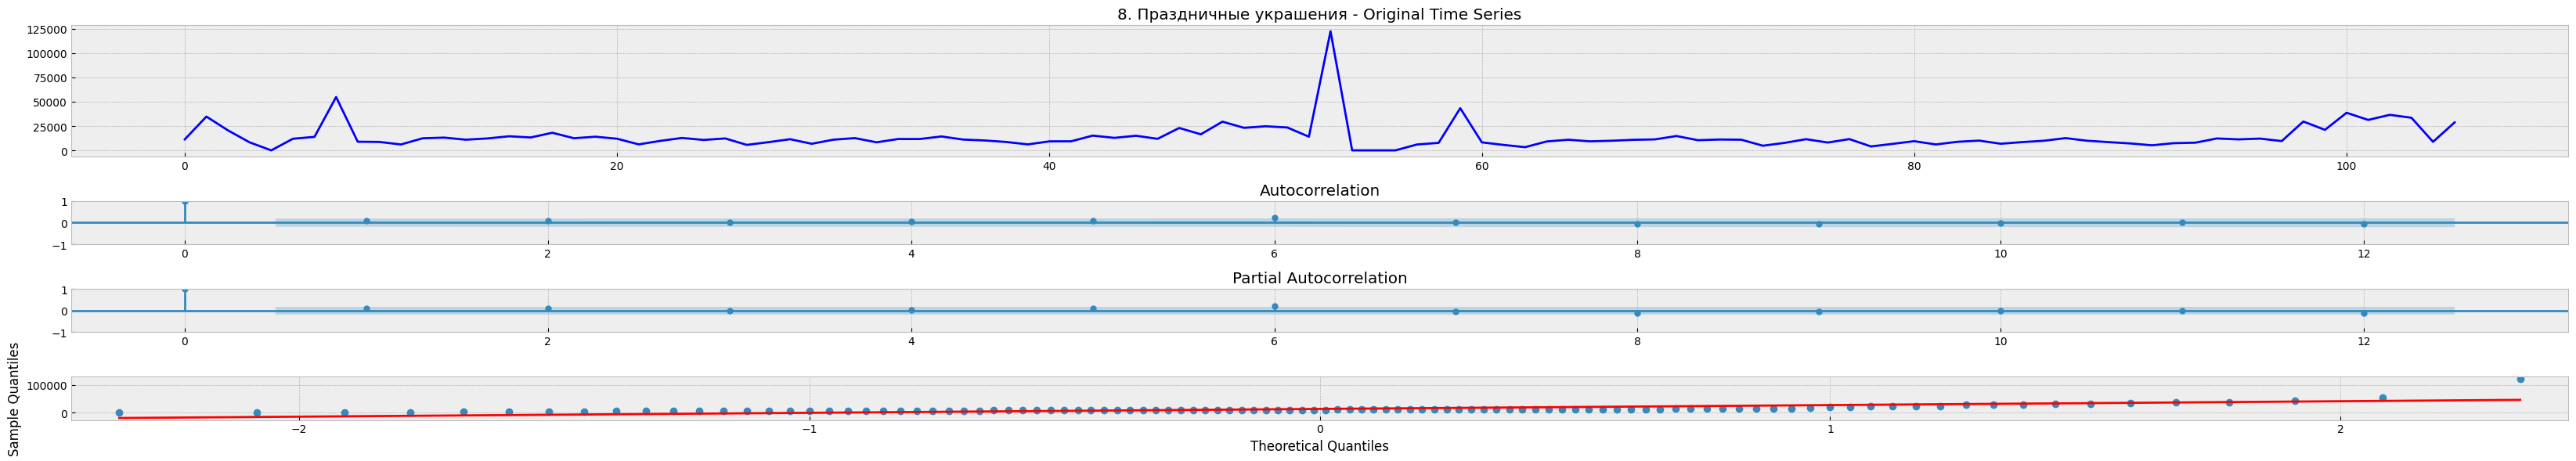

21:57:59 - cmdstanpy - INFO - Chain [1] start processing
21:57:59 - cmdstanpy - INFO - Chain [1] done processing


Baseline MSE: 4.35e+07, MAE: 4.15e+03, R²: 0.654


21:57:59 - cmdstanpy - INFO - Chain [1] start processing
21:58:00 - cmdstanpy - INFO - Chain [1] done processing
21:58:00 - cmdstanpy - INFO - Chain [1] start processing
21:58:00 - cmdstanpy - INFO - Chain [1] done processing
21:58:00 - cmdstanpy - INFO - Chain [1] start processing
21:58:00 - cmdstanpy - INFO - Chain [1] done processing
21:58:00 - cmdstanpy - INFO - Chain [1] start processing


Fold 1: MSE = 6.13e+10, MAE = 2.11e+05, R² = -11159.775
Fold 2: MSE = 7.97e+09, MAE = 5.70e+04, R² = -11.361
Fold 3: MSE = 3.67e+07, MAE = 5.26e+03, R² = -5.106
Fold 4: MSE = 8.57e+07, MAE = 6.35e+03, R² = 0.264


21:58:01 - cmdstanpy - INFO - Chain [1] done processing
21:58:01 - cmdstanpy - INFO - Chain [1] start processing
21:58:01 - cmdstanpy - INFO - Chain [1] done processing
21:58:01 - cmdstanpy - INFO - Chain [1] start processing
21:58:01 - cmdstanpy - INFO - Chain [1] done processing
21:58:01 - cmdstanpy - INFO - Chain [1] start processing
21:58:01 - cmdstanpy - INFO - Chain [1] done processing
21:58:02 - cmdstanpy - INFO - Chain [1] start processing
21:58:02 - cmdstanpy - INFO - Chain [1] done processing
21:58:02 - cmdstanpy - INFO - Chain [1] start processing
21:58:02 - cmdstanpy - INFO - Chain [1] done processing
21:58:02 - cmdstanpy - INFO - Chain [1] start processing
21:58:02 - cmdstanpy - INFO - Chain [1] done processing
21:58:03 - cmdstanpy - INFO - Chain [1] start processing
21:58:03 - cmdstanpy - INFO - Chain [1] done processing
21:58:03 - cmdstanpy - INFO - Chain [1] start processing
21:58:03 - cmdstanpy - INFO - Chain [1] done processing
21:58:03 - cmdstanpy - INFO - Chain [1] 

Best Prophet parameters: {'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'interval_width': 0.7}


21:58:07 - cmdstanpy - INFO - Chain [1] done processing


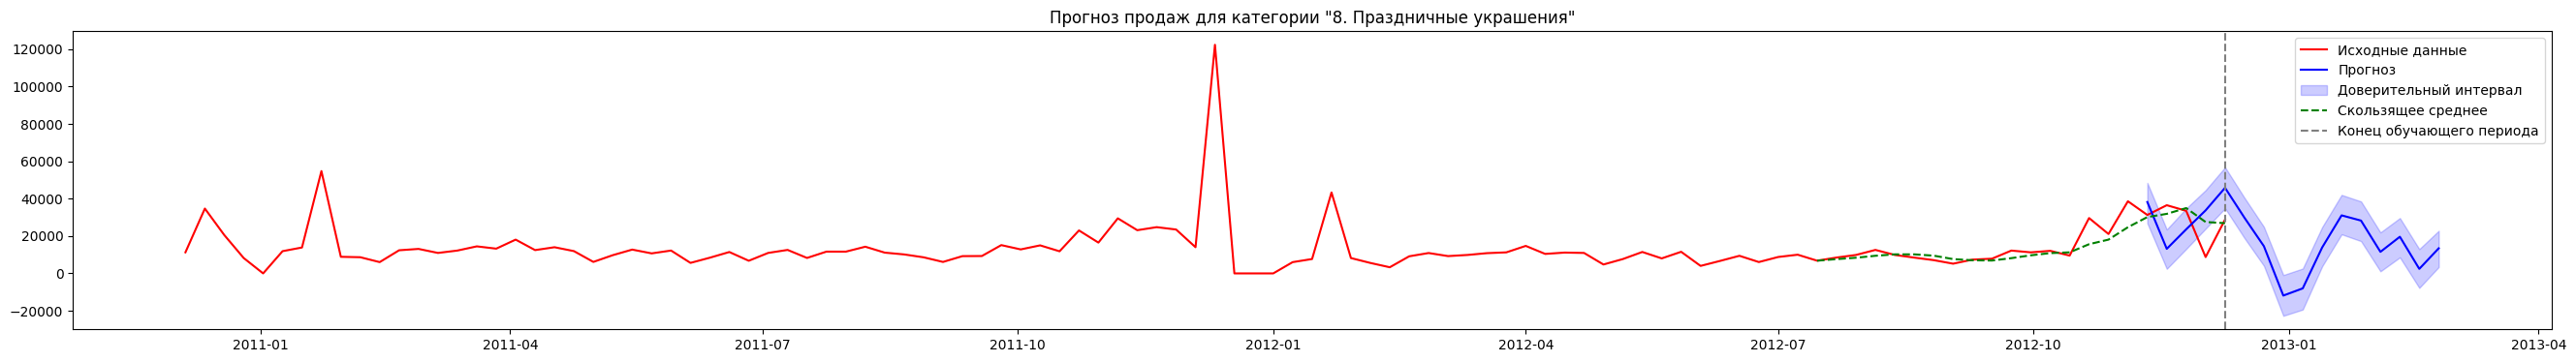

Prophet Model - MSE: 1.10e+08, MAE: 7.93e+03, R²: 0.077


Категория: 1. Стилизованные вещи интерьера с уникальным дизайном


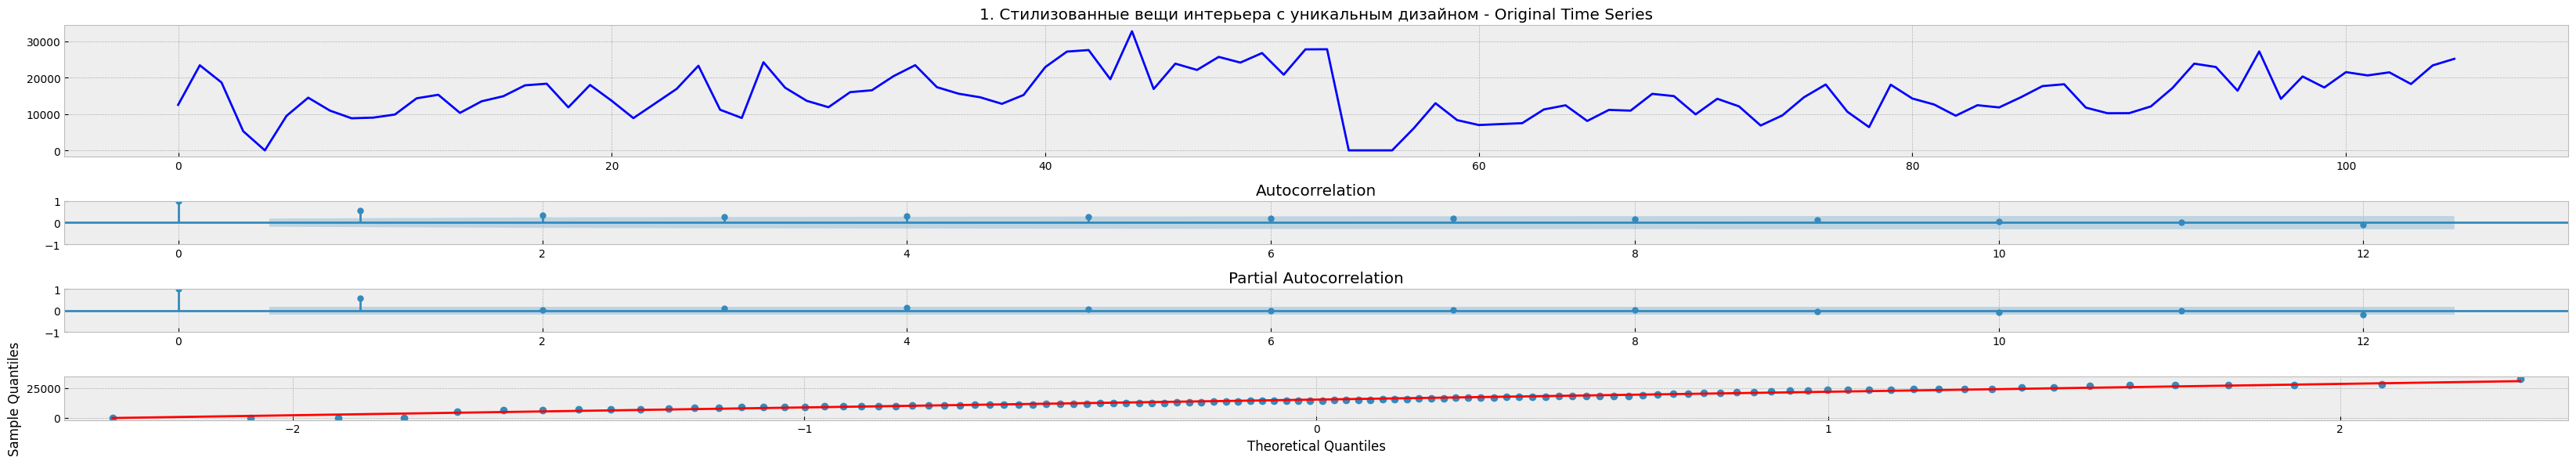

21:58:08 - cmdstanpy - INFO - Chain [1] start processing
21:58:08 - cmdstanpy - INFO - Chain [1] done processing


Baseline MSE: 1.36e+07, MAE: 3.22e+03, R²: 0.448


21:58:08 - cmdstanpy - INFO - Chain [1] start processing
21:58:08 - cmdstanpy - INFO - Chain [1] done processing
21:58:08 - cmdstanpy - INFO - Chain [1] start processing
21:58:09 - cmdstanpy - INFO - Chain [1] done processing
21:58:09 - cmdstanpy - INFO - Chain [1] start processing
21:58:09 - cmdstanpy - INFO - Chain [1] done processing
21:58:09 - cmdstanpy - INFO - Chain [1] start processing


Fold 1: MSE = 2.35e+11, MAE = 3.98e+05, R² = -9251.047
Fold 2: MSE = 1.67e+10, MAE = 7.79e+04, R² = -153.352
Fold 3: MSE = 8.94e+06, MAE = 2.38e+03, R² = 0.093
Fold 4: MSE = 8.99e+06, MAE = 2.26e+03, R² = 0.600


21:58:09 - cmdstanpy - INFO - Chain [1] done processing
21:58:09 - cmdstanpy - INFO - Chain [1] start processing
21:58:10 - cmdstanpy - INFO - Chain [1] done processing
21:58:10 - cmdstanpy - INFO - Chain [1] start processing
21:58:10 - cmdstanpy - INFO - Chain [1] done processing
21:58:10 - cmdstanpy - INFO - Chain [1] start processing
21:58:10 - cmdstanpy - INFO - Chain [1] done processing
21:58:11 - cmdstanpy - INFO - Chain [1] start processing
21:58:11 - cmdstanpy - INFO - Chain [1] done processing
21:58:11 - cmdstanpy - INFO - Chain [1] start processing
21:58:11 - cmdstanpy - INFO - Chain [1] done processing
21:58:11 - cmdstanpy - INFO - Chain [1] start processing
21:58:11 - cmdstanpy - INFO - Chain [1] done processing
21:58:12 - cmdstanpy - INFO - Chain [1] start processing
21:58:12 - cmdstanpy - INFO - Chain [1] done processing
21:58:12 - cmdstanpy - INFO - Chain [1] start processing
21:58:12 - cmdstanpy - INFO - Chain [1] done processing
21:58:12 - cmdstanpy - INFO - Chain [1] 

Best Prophet parameters: {'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'interval_width': 0.7}


21:58:17 - cmdstanpy - INFO - Chain [1] done processing


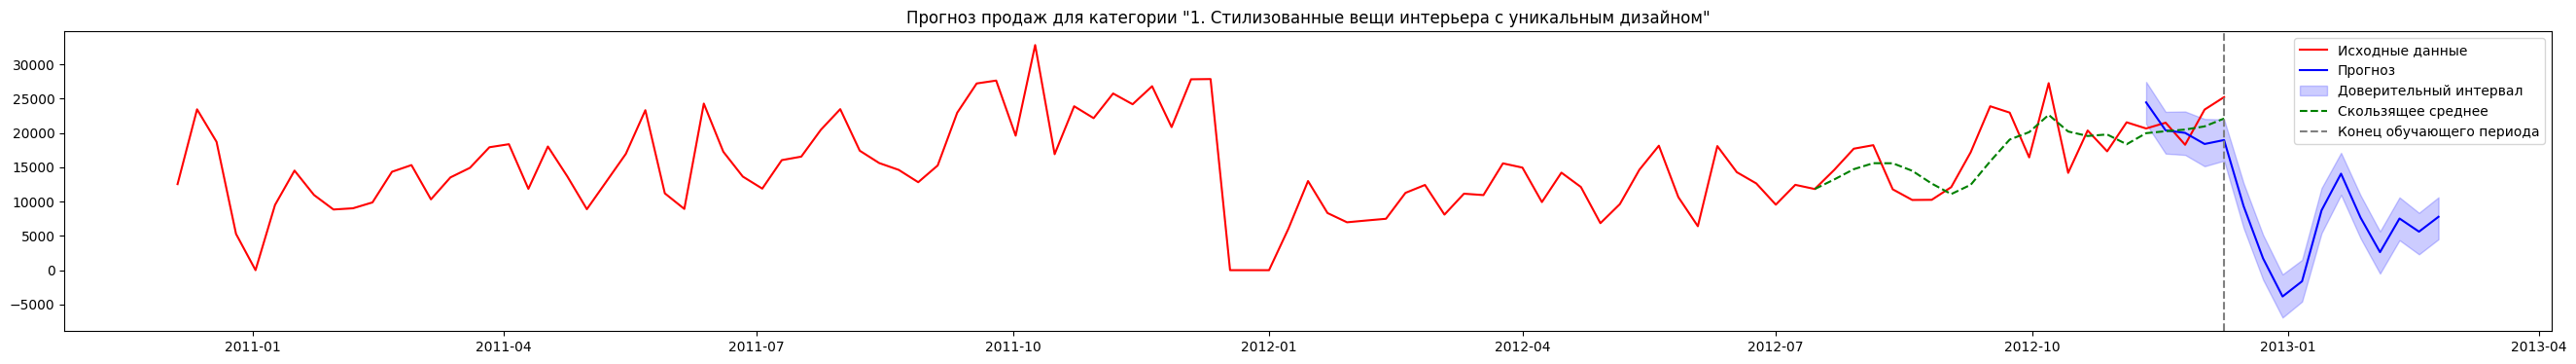

Prophet Model - MSE: 2.10e+07, MAE: 3.84e+03, R²: 0.122


Категория: 5. Игрушки или детские товары


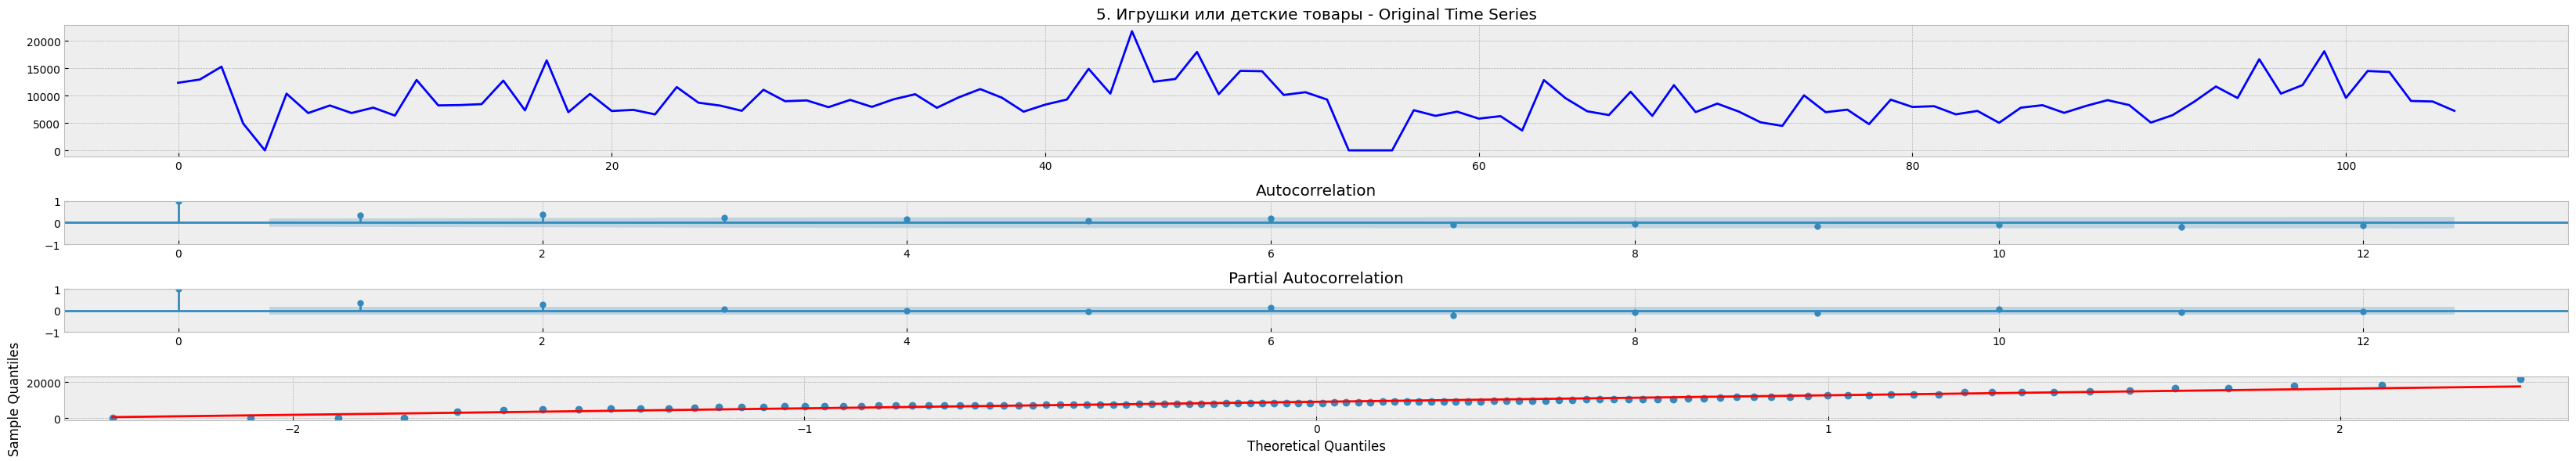

21:58:17 - cmdstanpy - INFO - Chain [1] start processing
21:58:17 - cmdstanpy - INFO - Chain [1] done processing


Baseline MSE: 5.24e+06, MAE: 1.79e+03, R²: 0.547


21:58:17 - cmdstanpy - INFO - Chain [1] start processing
21:58:17 - cmdstanpy - INFO - Chain [1] done processing
21:58:18 - cmdstanpy - INFO - Chain [1] start processing
21:58:18 - cmdstanpy - INFO - Chain [1] done processing
21:58:18 - cmdstanpy - INFO - Chain [1] start processing
21:58:18 - cmdstanpy - INFO - Chain [1] done processing
21:58:18 - cmdstanpy - INFO - Chain [1] start processing


Fold 1: MSE = 6.17e+09, MAE = 6.84e+04, R² = -3373.259
Fold 2: MSE = 1.36e+09, MAE = 2.21e+04, R² = -41.123
Fold 3: MSE = 8.47e+06, MAE = 2.49e+03, R² = -0.831
Fold 4: MSE = 5.22e+06, MAE = 1.81e+03, R² = 0.554


21:58:19 - cmdstanpy - INFO - Chain [1] done processing
21:58:19 - cmdstanpy - INFO - Chain [1] start processing
21:58:19 - cmdstanpy - INFO - Chain [1] done processing
21:58:19 - cmdstanpy - INFO - Chain [1] start processing
21:58:19 - cmdstanpy - INFO - Chain [1] done processing
21:58:20 - cmdstanpy - INFO - Chain [1] start processing
21:58:20 - cmdstanpy - INFO - Chain [1] done processing
21:58:20 - cmdstanpy - INFO - Chain [1] start processing
21:58:20 - cmdstanpy - INFO - Chain [1] done processing
21:58:20 - cmdstanpy - INFO - Chain [1] start processing
21:58:20 - cmdstanpy - INFO - Chain [1] done processing
21:58:21 - cmdstanpy - INFO - Chain [1] start processing
21:58:21 - cmdstanpy - INFO - Chain [1] done processing
21:58:21 - cmdstanpy - INFO - Chain [1] start processing
21:58:21 - cmdstanpy - INFO - Chain [1] done processing
21:58:21 - cmdstanpy - INFO - Chain [1] start processing
21:58:22 - cmdstanpy - INFO - Chain [1] done processing
21:58:22 - cmdstanpy - INFO - Chain [1] 

Best Prophet parameters: {'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'interval_width': 0.7}


21:58:26 - cmdstanpy - INFO - Chain [1] done processing


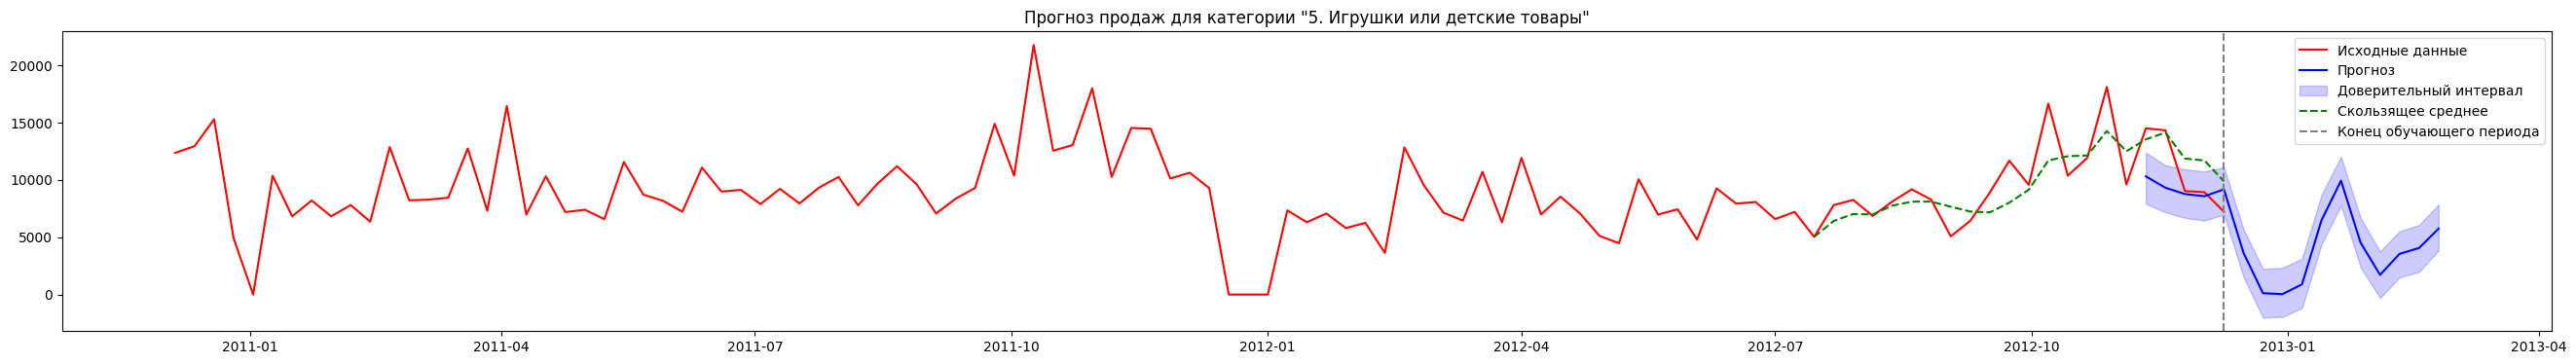

Prophet Model - MSE: 9.36e+06, MAE: 2.49e+03, R²: 0.185


Категория: 9. Браслеты бижутерия


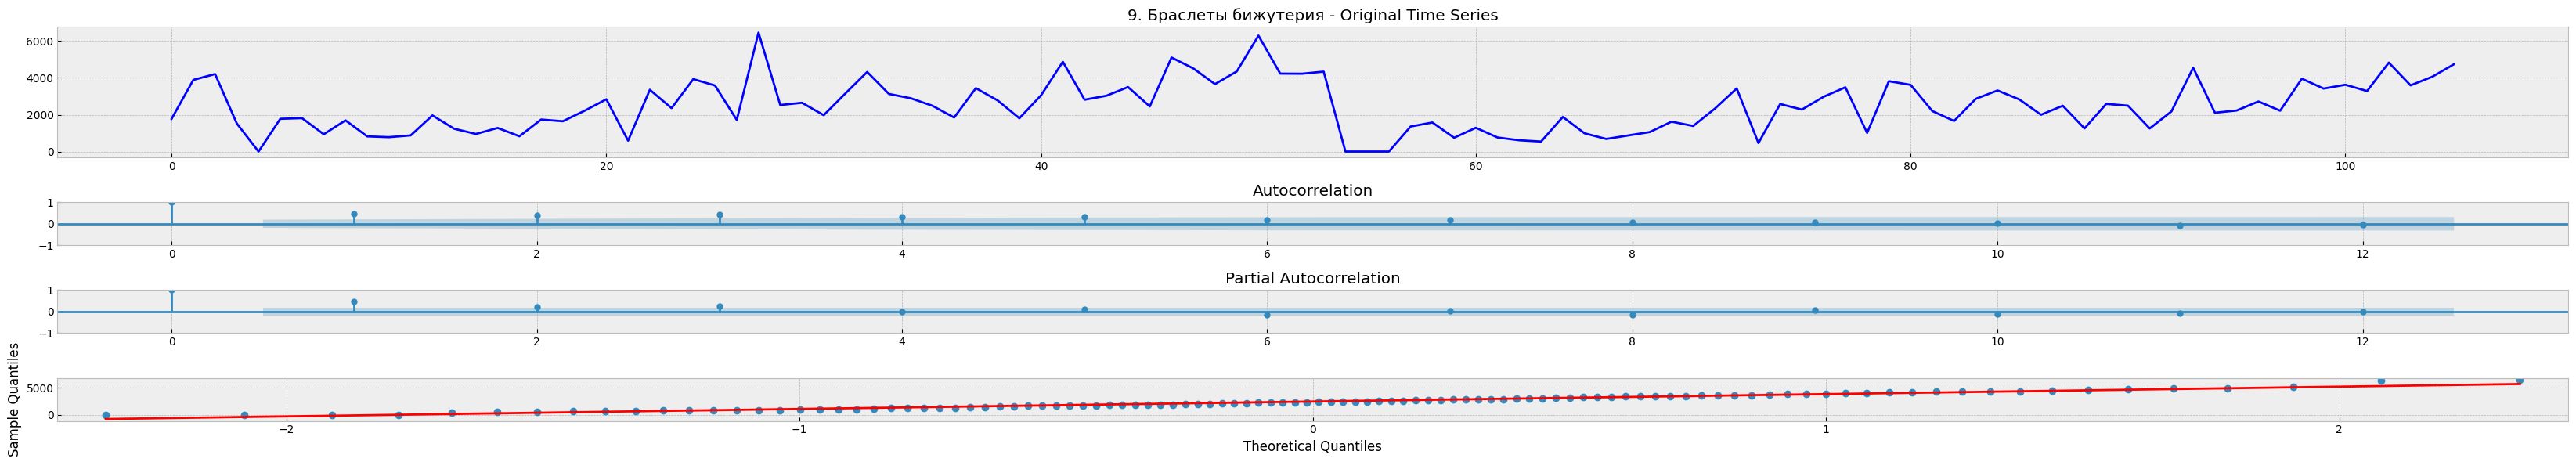

21:58:27 - cmdstanpy - INFO - Chain [1] start processing
21:58:27 - cmdstanpy - INFO - Chain [1] done processing


Baseline MSE: 4.65e+05, MAE: 5.09e+02, R²: 0.586


21:58:27 - cmdstanpy - INFO - Chain [1] start processing
21:58:27 - cmdstanpy - INFO - Chain [1] done processing
21:58:27 - cmdstanpy - INFO - Chain [1] start processing
21:58:27 - cmdstanpy - INFO - Chain [1] done processing
21:58:27 - cmdstanpy - INFO - Chain [1] start processing
21:58:28 - cmdstanpy - INFO - Chain [1] done processing
21:58:28 - cmdstanpy - INFO - Chain [1] start processing


Fold 1: MSE = 1.69e+09, MAE = 3.51e+04, R² = -1137.096
Fold 2: MSE = 1.39e+09, MAE = 2.21e+04, R² = -401.824
Fold 3: MSE = 6.87e+05, MAE = 5.66e+02, R² = 0.386
Fold 4: MSE = 5.92e+05, MAE = 6.74e+02, R² = 0.355


21:58:28 - cmdstanpy - INFO - Chain [1] done processing
21:58:28 - cmdstanpy - INFO - Chain [1] start processing
21:58:28 - cmdstanpy - INFO - Chain [1] done processing
21:58:28 - cmdstanpy - INFO - Chain [1] start processing
21:58:28 - cmdstanpy - INFO - Chain [1] done processing
21:58:28 - cmdstanpy - INFO - Chain [1] start processing
21:58:29 - cmdstanpy - INFO - Chain [1] done processing
21:58:29 - cmdstanpy - INFO - Chain [1] start processing
21:58:29 - cmdstanpy - INFO - Chain [1] done processing
21:58:29 - cmdstanpy - INFO - Chain [1] start processing
21:58:29 - cmdstanpy - INFO - Chain [1] done processing
21:58:29 - cmdstanpy - INFO - Chain [1] start processing
21:58:29 - cmdstanpy - INFO - Chain [1] done processing
21:58:30 - cmdstanpy - INFO - Chain [1] start processing
21:58:30 - cmdstanpy - INFO - Chain [1] done processing
21:58:30 - cmdstanpy - INFO - Chain [1] start processing
21:58:30 - cmdstanpy - INFO - Chain [1] done processing
21:58:30 - cmdstanpy - INFO - Chain [1] 

Best Prophet parameters: {'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'interval_width': 0.7}


21:58:34 - cmdstanpy - INFO - Chain [1] done processing


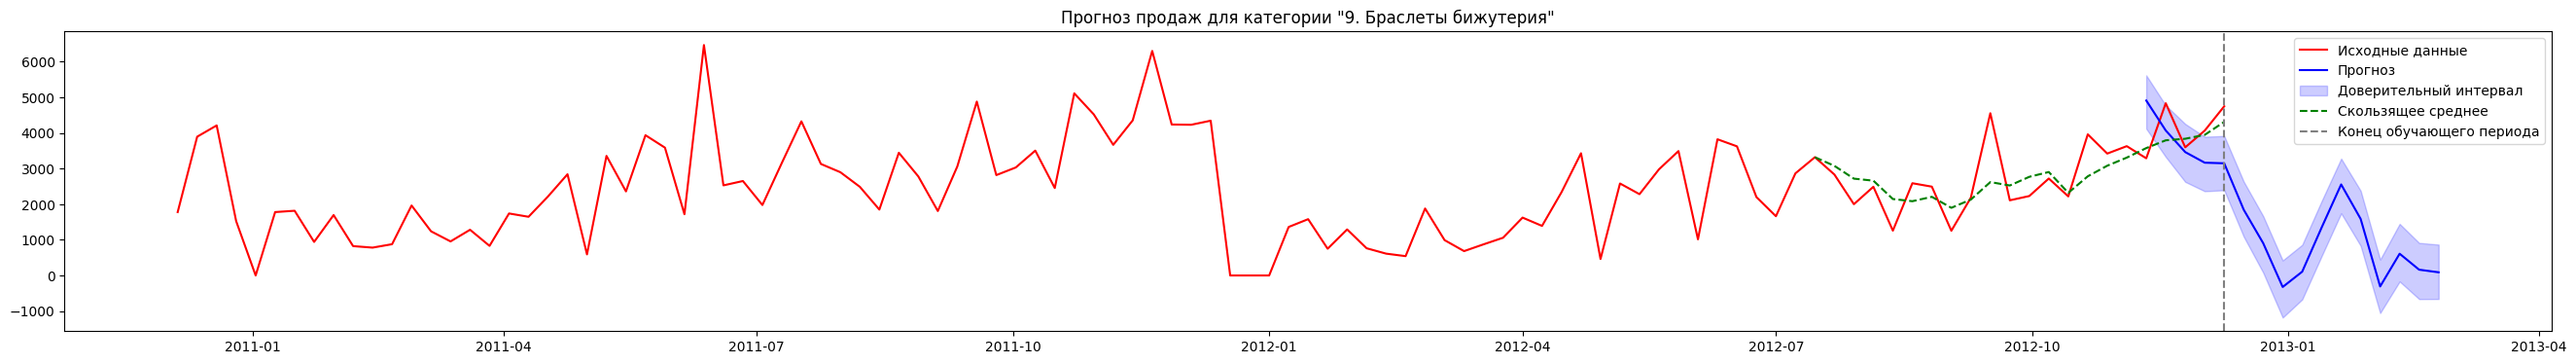

Prophet Model - MSE: 1.08e+06, MAE: 8.94e+02, R²: -0.052


Категория: 3. Часы и рождественские украшения


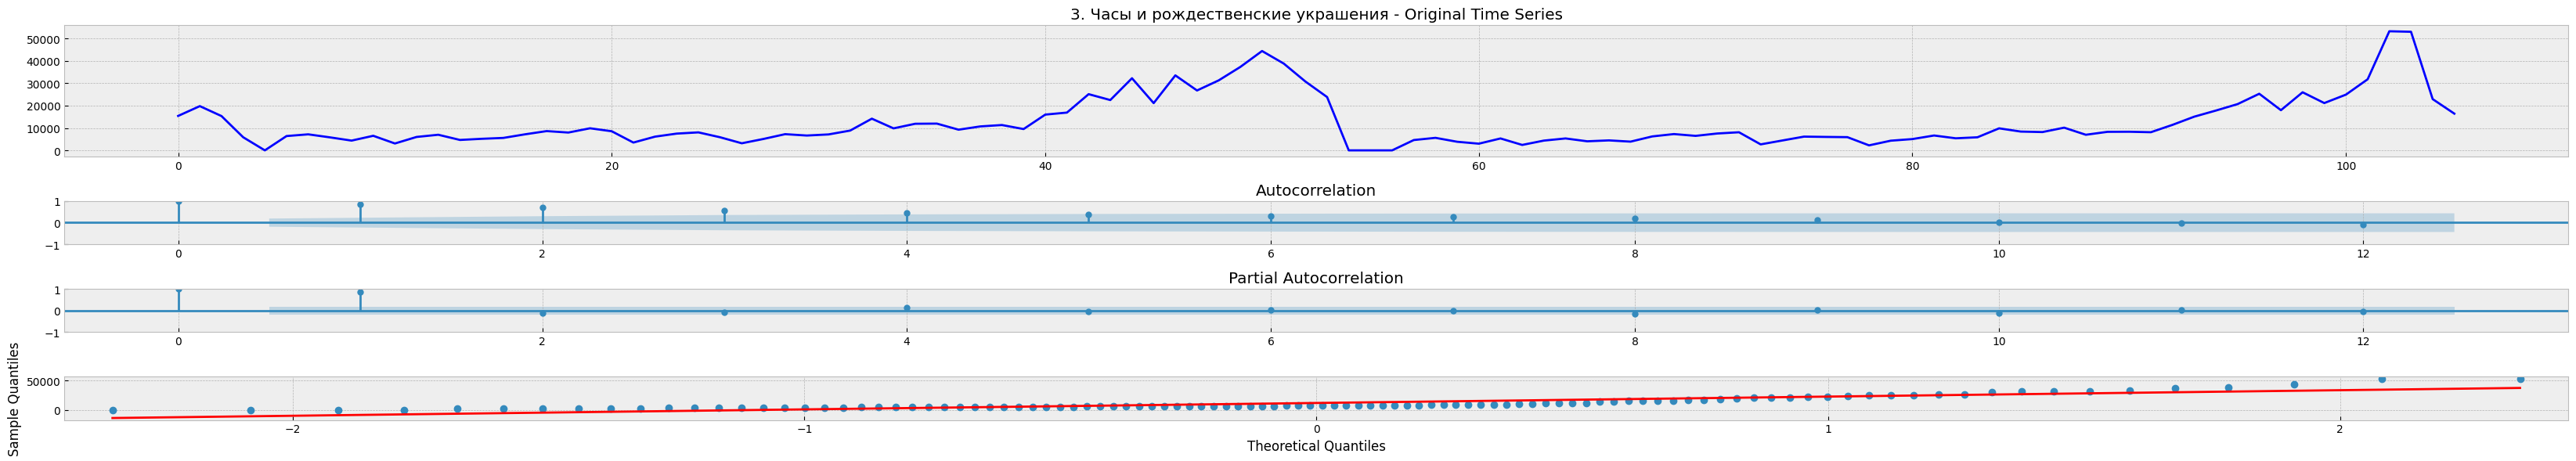

21:58:35 - cmdstanpy - INFO - Chain [1] start processing
21:58:35 - cmdstanpy - INFO - Chain [1] done processing


Baseline MSE: 7.53e+07, MAE: 5.79e+03, R²: 0.555


21:58:35 - cmdstanpy - INFO - Chain [1] start processing
21:58:35 - cmdstanpy - INFO - Chain [1] done processing
21:58:35 - cmdstanpy - INFO - Chain [1] start processing
21:58:35 - cmdstanpy - INFO - Chain [1] done processing
21:58:35 - cmdstanpy - INFO - Chain [1] start processing
21:58:36 - cmdstanpy - INFO - Chain [1] done processing
21:58:36 - cmdstanpy - INFO - Chain [1] start processing


Fold 1: MSE = 7.01e+10, MAE = 2.23e+05, R² = -5307.683
Fold 2: MSE = 1.61e+10, MAE = 8.36e+04, R² = -72.556
Fold 3: MSE = 1.39e+06, MAE = 9.28e+02, R² = 0.362
Fold 4: MSE = 3.25e+07, MAE = 3.86e+03, R² = 0.810


21:58:36 - cmdstanpy - INFO - Chain [1] done processing
21:58:36 - cmdstanpy - INFO - Chain [1] start processing
21:58:36 - cmdstanpy - INFO - Chain [1] done processing
21:58:36 - cmdstanpy - INFO - Chain [1] start processing
21:58:36 - cmdstanpy - INFO - Chain [1] done processing
21:58:37 - cmdstanpy - INFO - Chain [1] start processing
21:58:37 - cmdstanpy - INFO - Chain [1] done processing
21:58:37 - cmdstanpy - INFO - Chain [1] start processing
21:58:37 - cmdstanpy - INFO - Chain [1] done processing
21:58:37 - cmdstanpy - INFO - Chain [1] start processing
21:58:37 - cmdstanpy - INFO - Chain [1] done processing
21:58:37 - cmdstanpy - INFO - Chain [1] start processing
21:58:38 - cmdstanpy - INFO - Chain [1] done processing
21:58:38 - cmdstanpy - INFO - Chain [1] start processing
21:58:38 - cmdstanpy - INFO - Chain [1] done processing
21:58:38 - cmdstanpy - INFO - Chain [1] start processing
21:58:38 - cmdstanpy - INFO - Chain [1] done processing
21:58:38 - cmdstanpy - INFO - Chain [1] 

Best Prophet parameters: {'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'interval_width': 0.7}


21:58:42 - cmdstanpy - INFO - Chain [1] done processing


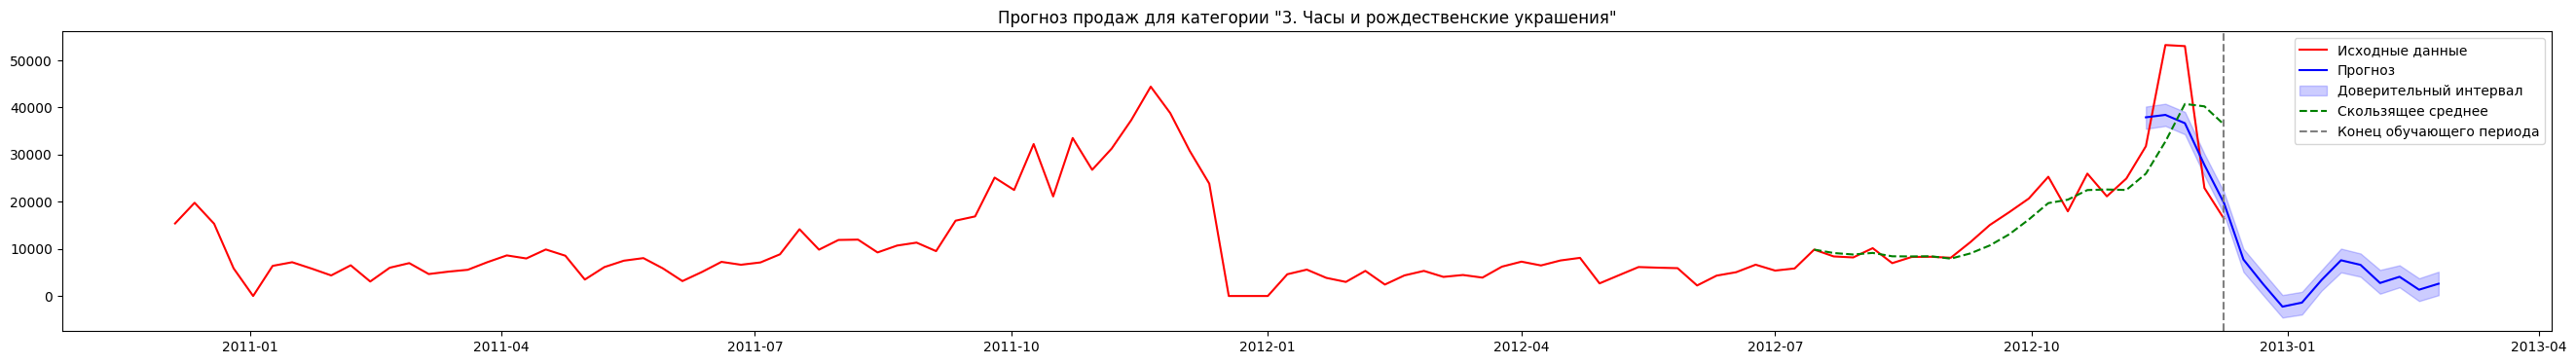

Prophet Model - MSE: 3.91e+07, MAE: 4.49e+03, R²: 0.761


Категория: 11. Прочие


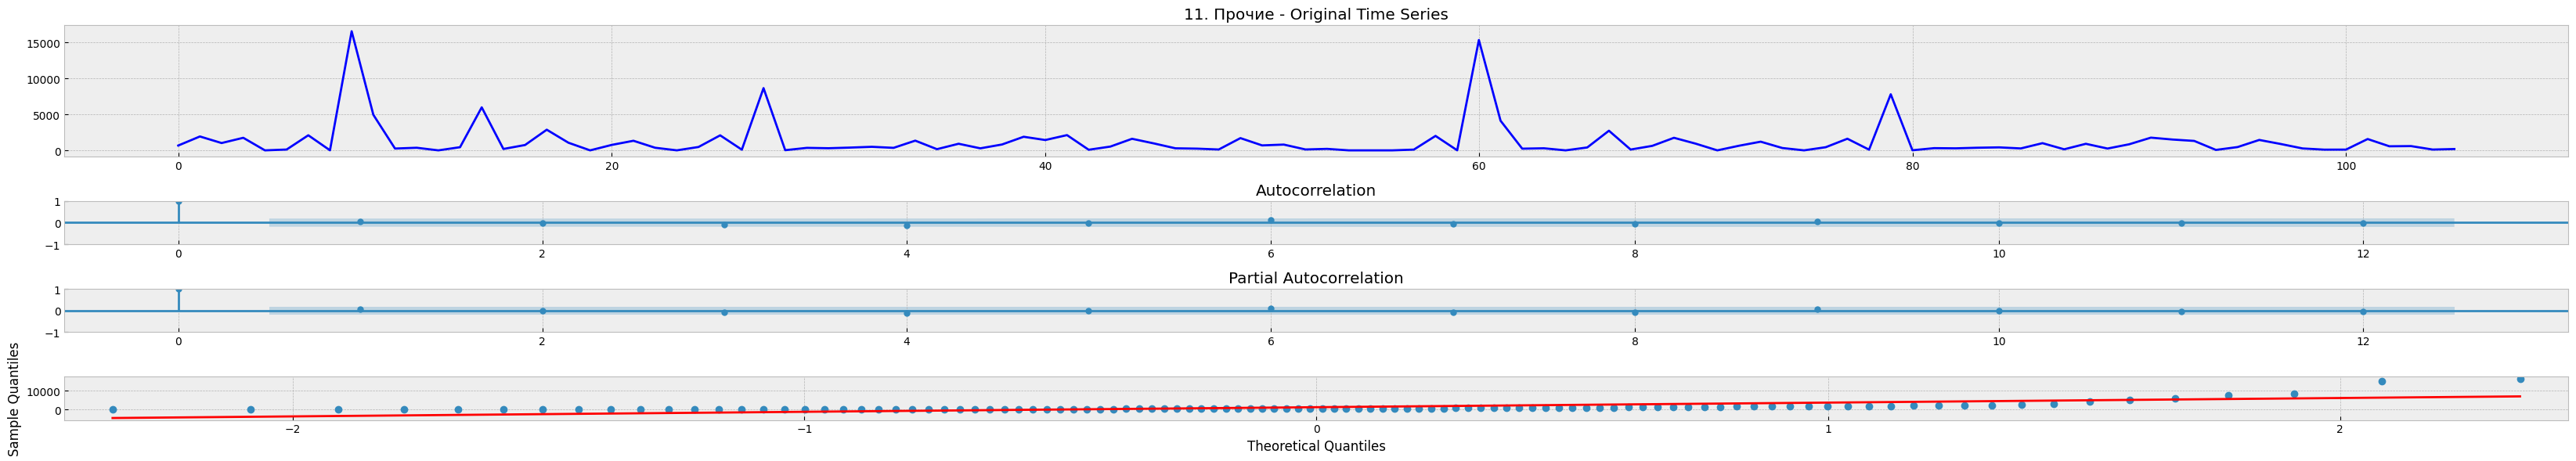

21:58:43 - cmdstanpy - INFO - Chain [1] start processing
21:58:43 - cmdstanpy - INFO - Chain [1] done processing


Baseline MSE: 2.73e+05, MAE: 4.27e+02, R²: 0.148


21:58:43 - cmdstanpy - INFO - Chain [1] start processing
21:58:43 - cmdstanpy - INFO - Chain [1] done processing
21:58:43 - cmdstanpy - INFO - Chain [1] start processing
21:58:44 - cmdstanpy - INFO - Chain [1] done processing
21:58:44 - cmdstanpy - INFO - Chain [1] start processing
21:58:44 - cmdstanpy - INFO - Chain [1] done processing
21:58:44 - cmdstanpy - INFO - Chain [1] start processing


Fold 1: MSE = 1.59e+09, MAE = 3.41e+04, R² = -485.791
Fold 2: MSE = 1.06e+10, MAE = 6.00e+04, R² = -999.256
Fold 3: MSE = 3.33e+06, MAE = 1.39e+03, R² = -0.187
Fold 4: MSE = 3.09e+05, MAE = 4.15e+02, R² = -0.049


21:58:44 - cmdstanpy - INFO - Chain [1] done processing
21:58:44 - cmdstanpy - INFO - Chain [1] start processing
21:58:44 - cmdstanpy - INFO - Chain [1] done processing
21:58:44 - cmdstanpy - INFO - Chain [1] start processing
21:58:45 - cmdstanpy - INFO - Chain [1] done processing
21:58:45 - cmdstanpy - INFO - Chain [1] start processing
21:58:45 - cmdstanpy - INFO - Chain [1] done processing
21:58:45 - cmdstanpy - INFO - Chain [1] start processing
21:58:45 - cmdstanpy - INFO - Chain [1] done processing
21:58:45 - cmdstanpy - INFO - Chain [1] start processing
21:58:45 - cmdstanpy - INFO - Chain [1] done processing
21:58:45 - cmdstanpy - INFO - Chain [1] start processing
21:58:46 - cmdstanpy - INFO - Chain [1] done processing
21:58:46 - cmdstanpy - INFO - Chain [1] start processing
21:58:46 - cmdstanpy - INFO - Chain [1] done processing
21:58:46 - cmdstanpy - INFO - Chain [1] start processing
21:58:46 - cmdstanpy - INFO - Chain [1] done processing
21:58:46 - cmdstanpy - INFO - Chain [1] 

Best Prophet parameters: {'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'interval_width': 0.7}


21:58:50 - cmdstanpy - INFO - Chain [1] done processing


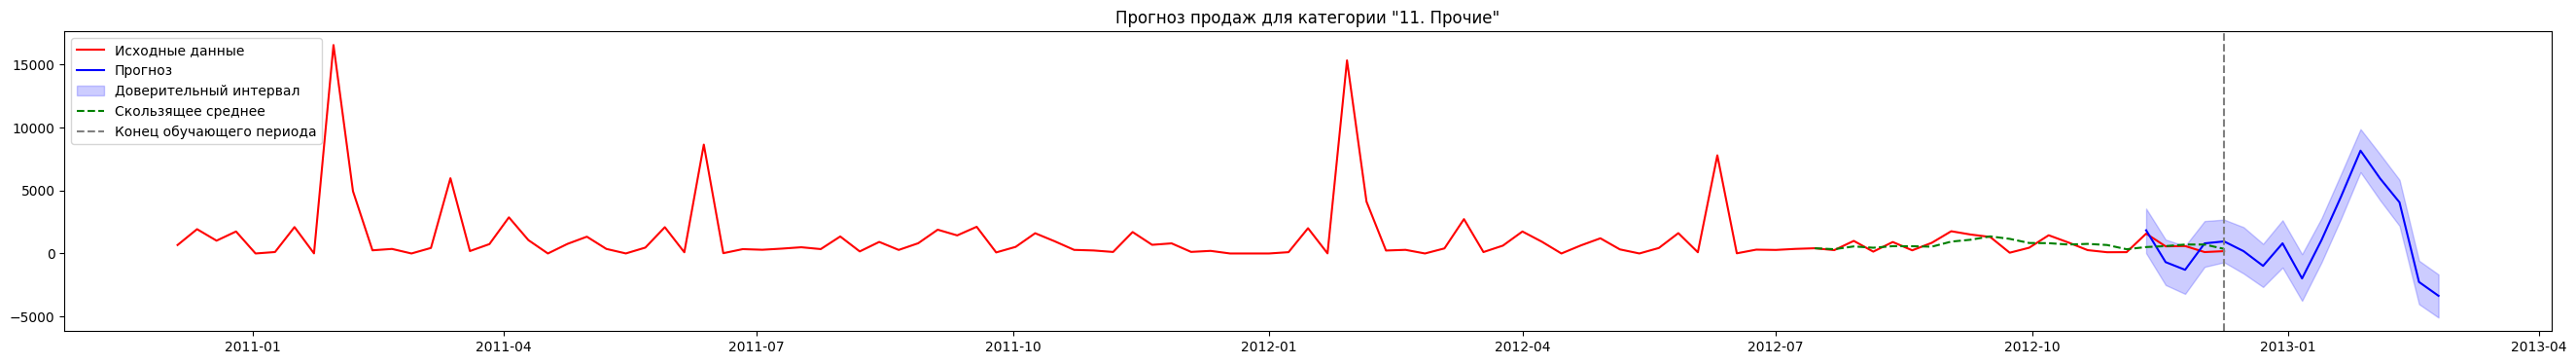

Prophet Model - MSE: 1.36e+06, MAE: 1.01e+03, R²: -3.644


In [22]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df_with_category['Дата'] = pd.to_datetime(df_with_category['InvoiceDate'])
categories = df_with_category['category_name'].unique()

def tsplot(name, y, lags=None, figsize=(33, 6), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Original')
        ts_ax.set_title(name)

        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
        plt.show()

def evaluate_prophet_model(model, test):
    future = pd.DataFrame({'ds': pd.date_range(start=test['ds'].iloc[0], periods=len(test), freq='W')})
    forecast = model.predict(future)
    predictions = forecast['yhat'].values
    mse = mean_squared_error(test['y'], predictions)
    mae = mean_absolute_error(test['y'], predictions)
    r2 = r2_score(test['y'], predictions)
    return mse, mae, r2

def evaluate_arima_model(train, test):
    model = ARIMA(train['y'], order=(5, 1, 0))
    model_fit = model.fit()
    predictions = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)
    mse = mean_squared_error(test['y'], predictions)
    mae = mean_absolute_error(test['y'], predictions)
    r2 = r2_score(test['y'], predictions)
    return mse, mae, r2

def evaluate_exponential_smoothing_model(train, test):
    model = ExponentialSmoothing(train['y'], seasonal='add', seasonal_periods=52)
    model_fit = model.fit()
    predictions = model_fit.predict(start=test.index[0], end=test.index[-1])
    mse = mean_squared_error(test['y'], predictions)
    mae = mean_absolute_error(test['y'], predictions)
    r2 = r2_score(test['y'], predictions)
    return mse, mae, r2

def baseline_model(test, window=4):
    baseline_predictions = test['y'].rolling(window=window, min_periods=1).mean()
    mse = mean_squared_error(test['y'][window-1:], baseline_predictions[window-1:])
    mae = mean_absolute_error(test['y'][window-1:], baseline_predictions[window-1:])
    r2 = r2_score(test['y'][window-1:], baseline_predictions[window-1:])
    return mse, mae, r2, baseline_predictions

def rolling_window_forecast(data, n_splits=5):
    n = len(data) // n_splits
    results = []
    for i in range(1, n_splits):
        train = data[:n * i]
        test = data[n * i:n * (i + 1)]
        
        model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
        model.fit(train)
        
        mse, mae, r2 = evaluate_prophet_model(model, test)
        results.append((mse, mae, r2))
    
    return results

def optimize_prophet_params(train, test):
    param_grid = {
        'yearly_seasonality': [True, False],
        'weekly_seasonality': [True, False],
        'daily_seasonality': [True, False],
        'interval_width': [0.7, 0.85, 0.95],
    }
    
    best_params = None
    best_mse = float('inf')
    
    for yearly in param_grid['yearly_seasonality']:
        for weekly in param_grid['weekly_seasonality']:
            for daily in param_grid['daily_seasonality']:
                for interval in param_grid['interval_width']:
                    model = Prophet(
                        yearly_seasonality=yearly,
                        weekly_seasonality=weekly,
                        daily_seasonality=daily,
                        interval_width=interval
                    )
                    model.fit(train)
                    mse, _, _ = evaluate_prophet_model(model, test)
                    
                    if mse < best_mse:
                        best_mse = mse
                        best_params = {
                            'yearly_seasonality': yearly,
                            'weekly_seasonality': weekly,
                            'daily_seasonality': daily,
                            'interval_width': interval
                        }
                            
    return best_params

results_summary = []

for category in categories:
    if pd.isna(category):
        continue
    print(f"\n\nКатегория: {category}")
    
    filtered_sales_data = df_with_category[
        (df_with_category['category_name'] == category)
    ]
    
    sales_data = filtered_sales_data.groupby('Дата')['Quantity'].sum()
    monthly_sales = sales_data.resample('W').sum().reset_index()
    monthly_sales.columns = ['ds', 'y']
    monthly_sales['ds'] = pd.to_datetime(monthly_sales['ds'])
    monthly_sales['y'] = pd.to_numeric(monthly_sales['y'], errors='coerce')
    
    if len(monthly_sales) == 0:
        print(f"Нет данных для категории '{category}'.")
        continue
    
    train_size = int(len(monthly_sales) * 0.8)
    train, test = monthly_sales[:train_size], monthly_sales[train_size:]
    
    tsplot(name=f'{category} - Original Time Series', y=monthly_sales['y'], lags=12)
    
    baseline_mse, baseline_mae, baseline_r2, baseline_predictions = baseline_model(test, window=4)
    print(f'Baseline MSE: {baseline_mse:.2e}, MAE: {baseline_mae:.2e}, R²: {baseline_r2:.3f}')
    
    rolling_results = rolling_window_forecast(monthly_sales)
    for i, (mse, mae, r2) in enumerate(rolling_results):
        print(f"Fold {i+1}: MSE = {mse:.2e}, MAE = {mae:.2e}, R² = {r2:.3f}")
    
    best_params = optimize_prophet_params(train, test)
    print(f"Best Prophet parameters: {best_params}")
    
    model = Prophet(
        yearly_seasonality=best_params['yearly_seasonality'],
        weekly_seasonality=best_params['weekly_seasonality'],
        daily_seasonality=best_params['daily_seasonality'],
        interval_width=best_params['interval_width']
    )
    model.add_seasonality(name='year', period=30.5, fourier_order=6)
    model.fit(train)
    
    future = pd.DataFrame({'ds': pd.date_range(start=monthly_sales['ds'].max() - pd.DateOffset(weeks=4), 
                                              periods=16, freq='W')})
    forecast = model.predict(future)
    
    plt.figure(figsize=(33, 4))
    ax = plt.gca()
    plt.plot(monthly_sales['ds'], monthly_sales['y'], color='red', label='Исходные данные')
    plt.plot(forecast['ds'], forecast['yhat'], color='blue', label='Прогноз')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Доверительный интервал')
    
    plt.plot(test['ds'], baseline_predictions, color='green', linestyle='--', label='Скользящее среднее')
    
    plt.axvline(x=monthly_sales['ds'].max(), color='grey', linestyle='--', label='Конец обучающего периода')
    plt.title(f'Прогноз продаж для категории "{category}"')
    plt.legend()
    plt.show()
    
    prophet_mse, prophet_mae, prophet_r2 = evaluate_prophet_model(model, test)
    print(f'Prophet Model - MSE: {prophet_mse:.2e}, MAE: {prophet_mae:.2e}, R²: {prophet_r2:.3f}')
    
    results_summary.append({
        'Category': category,
        'Baseline MSE': baseline_mse,
        'Baseline MAE': baseline_mae,
        'Baseline R²': baseline_r2,
        'Prophet MSE': prophet_mse,
        'Prophet MAE': prophet_mae,
        'Prophet R²': prophet_r2,
        'Best Prophet Parameters': best_params
    })


In [23]:
# Преобразование в DataFrame и вывод таблицы
results_df = pd.DataFrame(results_summary)
results_df

Category  Baseline MSE  \
0                                  7. Декор для дома  1.890789e+07   
1                               6. Свечи и освещение  1.127422e+07   
2                    4. Кухонные аксессуары и посуда  8.003183e+07   
3  2. Стеклянные и керамические аксессуары (оформ...  5.283409e+07   
4                           8. Праздничные украшения  4.353351e+07   
5  1. Стилизованные вещи интерьера с уникальным д...  1.364643e+07   
6                      5. Игрушки или детские товары  5.240364e+06   
7                              9. Браслеты бижутерия  4.651652e+05   
8                 3. Часы и рождественские украшения  7.531862e+07   
9                                         11. Прочие  2.732996e+05   

   Baseline MAE  Baseline R²   Prophet MSE  Prophet MAE  Prophet R²  \
0   3342.723684     0.684877  1.848973e+07  3315.071250    0.729523   
1   2185.328947     0.643953  2.253267e+07  3962.301665    0.320746   
2   7222.868421     0.426662  6.589700e+07  6478.019519    0.495356   
3   5454.565789     0.422399  5.362271e+07  6075.268235    0.477214   
4   4145.197368     0.654384  1.095873e+08  7927.023640    0.076631   
5   3223.578947     0.448022  2.097828e+07  3840.286861    0.121624   
6   1786.486842     0.547259  9.362651e+06  2493.913050    0.185415   
7    509.197368     0.586350  1.076343e+06   893.679541   -0.051781   
8   5792.407895     0.555005  3.908192e+07  4488.381398    0.761454   
9    426.539474     0.147828  1.358731e+06  1014.865336   -3.644213   

                             Best Prophet Parameters  
0  {'yearly_seasonality': True, 'weekly_seasonali...  
1  {'yearly_seasonality': True, 'weekly_seasonali...  
2  {'yearly_seasonality': True, 'weekly_seasonali...  
3  {'yearly_seasonality': True, 'weekly_seasonali...  
4  {'yearly_seasonality': True, 'weekly_seasonali...  
5  {'yearly_seasonality': True, 'weekly_seasonali...  
6  {'yearly_seasonality': True, 'weekly_seasonali...  
7  {'yearly_seasonality': True, 'weekly_seasonali...  
8  {'yearly_seasonality': True, 'weekly_seasonali...  
9  {'yearly_seasonality': True, 'weekly_seasonali...

# Итоговый отчет по проекту: Прогнозирование товарных остатков в онлайн-ритейле

## Основные этапы и результаты

### 1. Загрузка и предварительная обработка данных
- На первом этапе были загружены данные из Excel и проведена их очистка. Были заменены пропущенные значения, устранены некорректные записи, и обработаны описания товаров для дальнейшего анализа. Данный этап обеспечил высокое качество исходных данных, необходимых для дальнейшего моделирования.

### 2. Кластеризация товаров
- С помощью текстовых моделей были преобразованы описания товаров в эмбеддинги, что позволило применить метод кластеризации K-Means для разделения товаров на категории. В процессе анализа была выбрана оптимальная модель (`paraphrase-MiniLM-L6-v2`), показавшая наилучший результат на основе метрики силуэта.
- В результате были созданы 9 категорий товаров, каждая из которых была логически именована в соответствии с содержанием товаров в кластерах. Это позволило структурировать ассортимент для дальнейшего прогнозирования.

### 3. Анализ временных рядов и прогнозирование продаж
- Проведен анализ временных рядов продаж для каждой из выделенных категорий. Данные были агрегированы по неделям, что позволило визуализировать динамику продаж по категориям.
- Для оценки моделей временных рядов использовались метрики:
  - Среднеквадратическая ошибка (`MSE`)
  - Средняя абсолютная ошибка (`MAE`)
  - Коэффициент детерминации (`R²`)
  - Средняя абсолютная процентная ошибка (`MAPE`)
  - Сравнение с базовой линией построенной на основании скользящего среднего
- Для прогнозирования продаж была применена модель `Prophet`, которая показала высокую точность на тестовых данных. Построенные прогнозы охватывали период в `12 недель`, с использованием данных последних `4 недель` в качестве исторического контекста.

## Результаты и выводы
- **Кластеризация товаров:** Кластеризация позволила логически структурировать ассортимент, что облегчит управление запасами и оптимизацию маркетинга.
- **Анализ временных рядов:** Выявление сезонных и трендовых паттернов позволяет более точно прогнозировать спрос, что важно для управления товарными остатками.
- **Прогнозирование продаж:** Модель `Prophet` продемонстрировала высокую точность, что позволяет уверенно использовать её для прогнозирования будущих продаж и планирования запасов.

- Хорошие результаты для моделей:
    `3. Часы и рождественские украшения:` Prophet показал отличные результаты с высоким R² и низким MSE и MAE. Это может быть подходящим выбором для прогнозирования этой категории.
    `7. Декор для дома:` Prophet также показал хорошие результаты, несмотря на небольшое улучшение по сравнению с бейзлайном. Это может указывать на то, что Prophet подходит для этой категории.

- Общие рекомендации:
    Для категорий, где Prophet демонстрирует улучшение по метрикам (например, "Часы и рождественские украшения"), модель можно использовать для прогнозирования.
    Для категорий, где результаты Prophet хуже бейзлайна (например, "Свечи и освещение"), требуют более аккуратного использования или увеличения диапазона данных для прогнозирования и повышения качества модели

## Ценность для бизнеса

1. **Улучшение управления запасами:** Предложенная модель позволяет точнее прогнозировать остатки на складах, что минимизирует риски как дефицита, так и избыточных запасов, тем самым снижая затраты на хранение и улучшая удовлетворенность клиентов.
2. **Оптимизация маркетинговых стратегий:** Понимание сезонных колебаний и прогнозы позволяют запускать более целевые маркетинговые кампании, увеличивая конверсию и продажи.
3. **Повышение эффективности цепочек поставок:** Прогнозирование спроса на основе временных рядов помогает принимать более точные решения по закупкам и управлению цепочками поставок, что улучшает общую операционную эффективность бизнеса.

Этот проект создал основу для дальнейшего совершенствования инструментов прогнозирования в онлайн-ритейле, обеспечивая бизнес необходимыми аналитическими данными для принятия обоснованных решений.
(так же в данном проекте использовались мощности видеокарты для расчета данных, все данные взяты из открытых источников и не носят коммерческой тайны) 
